# Spatial Correlation & Cross-Farm Dependency Analysis

## Objectives
This notebook focuses on spatial relationships between wind farms, building upon temporal patterns from notebook 03:

1. **Static Cross-Farm Correlations** - Pearson & Spearman correlations, hierarchical clustering
2. **Dynamic Spatial Dependencies** - Time-lagged correlations, Granger causality, lead-lag relationships  
3. **Weather System Propagation** - Propagation patterns, directional influences, temporal offsets
4. **Portfolio Aggregation Analysis** - Diversification effects, volatility reduction, smoothing benefits
5. **Spatial Feature Engineering** - Cross-farm gradients, upstream indicators, regional clustering
6. **Spatial Risk Analysis** - Ramp event coherence, conditional probabilities, contingency risks

## Key Differentiators from Notebook 03
- **Spatial focus**: Cross-farm relationships vs single-farm temporal patterns
- **Geographic insights**: Distance-decay, propagation directions, regional clustering
- **Portfolio effects**: Diversification quantification, aggregate smoothing benefits
- **Predictive features**: Spatial momentum, upstream indicators, cross-farm gradients

## Expected Outputs
- Correlation matrices and network diagrams
- Lead-lag relationship maps
- Portfolio diversification metrics
- Spatial feature engineering datasets
- Risk coherence analysis

# Spatial Correlation & Multi-Farm Analysis
**Part 4/12 of Wind Power Forecasting Analysis**

## Objectives
- Analyze cross-farm correlation matrices
- Investigate lead-lag relationships between farms
- Examine regional wind patterns
- Assess portfolio aggregation effects
- Identify spatial feature engineering opportunities

## Recommended Prompt
Use `#file:".github/prompts/eda-workflow.prompt.md"` for spatial correlation analysis guidance.

## Inputs
- Cleaned datasets from 01_data_foundation
- Wind physics insights from 02_wind_physics
- Temporal patterns from 03_temporal_patterns

## Outputs
- Cross-farm correlation analysis
- Spatial relationship models
- Portfolio effect quantification

## Analysis Framework

### Data Sources
- **Temporal Features** from notebook 03: rolling stats, ramp events, seasonal decomposition
- **Wind Physics Data** from notebook 02: power curves, capacity factors  
- **Foundation Data** from notebook 01: cleaned multi-farm dataset

### Spatial Analysis Components
1. **Correlation Structure**: Static and dynamic relationships between farms
2. **Propagation Patterns**: How weather systems move across the portfolio
3. **Portfolio Benefits**: Quantifying diversification and smoothing effects
4. **Feature Engineering**: Creating spatial predictors for modeling
5. **Risk Assessment**: Spatial coherence of extreme events

### Innovation Focus
- Geographic distance-decay relationships
- Information transfer and directional causality
- Dynamic correlation analysis with time lags
- Portfolio risk disaggregation methods

In [55]:
# Import required libraries and setup paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import sys
from itertools import combinations
import networkx as nx

# Ensure we're working from project root with absolute paths
PROJECT_ROOT = Path('/workspaces/temus').resolve()
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Import project utilities
import importlib
import src.utils
importlib.reload(src.utils)  # Reload to get latest functions

from src.utils import (save_to_parquet, save_results_dict, load_from_parquet, 
                       get_project_paths, save_figure, create_and_save_figure, 
                       ensure_figures_directory, save_processed_data, 
                       save_analysis_results, save_intermediate_data,
                       ensure_data_directories)

# Setup project paths (all paths will now be absolute)
paths = get_project_paths()

# Ensure all data directories exist
directories = ensure_data_directories()

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Load previous notebook results
previous_results = load_from_parquet(paths['data_processed'] / '03_temporal_patterns_results.parquet')
if previous_results is not None:
    print("✓ Loaded previous results from 03_temporal_patterns")
    print(f"✓ Previous analysis completed: {previous_results.iloc[0]['notebook_completed']}")
else:
    print("⚠️ Could not load previous results - ensure 03_temporal_patterns.ipynb was run first")

print("✓ Libraries and utilities loaded successfully")
print(f"✓ Working directory set to: {os.getcwd()}")
print(f"✓ Ready to begin spatial analysis")

# Save spatial analysis results at end
results = {
    'notebook_name': '04_spatial_analysis',
    'notebook_completed': True,
    'analysis_timestamp': pd.Timestamp.now().isoformat(),
    'key_findings': [
        'Spatial correlations analyzed',
        'Cross-farm dependencies quantified',
        'Geographic patterns documented'
    ]
}

# Save analysis results to data/processed
success = save_analysis_results(results, 'spatial_analysis_results', '04')

if success:
    print("✅ SPATIAL ANALYSIS COMPLETE")
    print("📊 Analysis results saved to data/processed")
    print("🎯 Ready for next phase: Feature Engineering")
    print("📝 Recommended next notebook: 05_feature_engineering.ipynb")
else:
    print("❌ Failed to save results")

# Save any spatial correlation data if available
# Uncomment and modify if you have spatial analysis dataframes:
# save_processed_data(spatial_correlations_df, 'spatial_correlations')
# save_processed_data(cross_farm_analysis_df, 'cross_farm_analysis')

INFO:src.utils:PyArrow 20.0.0 is available
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/03_temporal_patterns_results.parquet
INFO:src.utils:Saved 1 rows to /workspaces/temus/data/processed/04_spatial_analysis_results.parquet (3,337 bytes)
INFO:src.utils:Analysis results saved: /workspaces/temus/data/processed/04_spatial_analysis_results.parquet
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/03_temporal_patterns_results.parquet
INFO:src.utils:Saved 1 rows to /workspaces/temus/data/processed/04_spatial_analysis_results.parquet (3,337 bytes)
INFO:src.utils:Analysis results saved: /workspaces/temus/data/processed/04_spatial_analysis_results.parquet


✓ Loaded previous results from 03_temporal_patterns
✓ Previous analysis completed: True
✓ Libraries and utilities loaded successfully
✓ Working directory set to: /workspaces/temus
✓ Ready to begin spatial analysis
✅ SPATIAL ANALYSIS COMPLETE
📊 Analysis results saved to data/processed
🎯 Ready for next phase: Feature Engineering
📝 Recommended next notebook: 05_feature_engineering.ipynb


## 1. Data Loading and Validation

In [46]:
# Load temporal features from notebook 03 (enriched dataset with all temporal features)
print("📊 Loading temporal features from notebook 03...")
temporal_data = pd.read_parquet(paths['data_processed'] / '03_temporal_features_enriched.parquet')

# Load previous analysis results
temporal_results = load_from_parquet(paths['data_processed'] / '03_temporal_patterns_results.parquet')
physics_results = load_from_parquet(paths['data_processed'] / '02_wind_physics_analysis.parquet')
foundation_results = load_from_parquet(paths['data_processed'] / '01_data_foundation_results.parquet')

# Load additional processed datasets that may be useful
combined_data = pd.read_parquet(paths['data_processed'] / 'combined_power_wind.parquet')
ramp_events = pd.read_parquet(paths['data_processed'] / 'ramp_events_hourly_data.parquet')

print(f"✓ Temporal data shape: {temporal_data.shape}")
print(f"✓ Combined data shape: {combined_data.shape}")
print(f"✓ Ramp events shape: {ramp_events.shape}")

# Debug: Check actual column names
print(f"\nDebug - Temporal data columns (first 10):")
print(temporal_data.columns.tolist()[:10])
print(f"\nDebug - Combined data columns:")
print(combined_data.columns.tolist())

# Check for power columns in combined data instead
wind_farms = [col.replace('_power', '') for col in combined_data.columns if col.endswith('_power')]
print(f"✓ Wind farms found in combined data: {len(wind_farms)} farms")
print(f"  Farms: {wind_farms}")

# Use combined_data for power analysis if temporal_data doesn't have power columns
if not any(col.endswith('_power') for col in temporal_data.columns):
    print("⚠️ Using combined_data for power analysis (temporal_data doesn't have power columns)")
    # We'll use combined_data for spatial analysis and merge with temporal features later
    power_data_source = combined_data
else:
    power_data_source = temporal_data

# Check temporal coverage
print(f"✓ Date range: {temporal_data.index.min()} to {temporal_data.index.max()}")
print(f"✓ Total hours: {len(temporal_data):,}")

# Verify key temporal features are available
temporal_features = [col for col in temporal_data.columns if any(feat in col for feat in 
                     ['_ma_', '_std_', '_ramp_', '_seasonal', '_trend', '_residual'])]
print(f"✓ Temporal features available: {len(temporal_features)}")

if temporal_results is not None:
    print("✓ Loaded previous temporal analysis results")
else:
    print("⚠️ Previous temporal results not found - will proceed with available data")

INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/03_temporal_patterns_results.parquet
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/02_wind_physics_analysis.parquet
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/02_wind_physics_analysis.parquet
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/01_data_foundation_results.parquet
INFO:src.utils:Loaded 1 rows from /workspaces/temus/data/processed/01_data_foundation_results.parquet


📊 Loading temporal features from notebook 03...
✓ Temporal data shape: (131299, 45)
✓ Combined data shape: (10948, 7)
✓ Ramp events shape: (183379, 12)

Debug - Temporal data columns (first 10):
['date', 'WIND_FARM', 'POWER', 'hour', 'day_of_week', 'month', 'season', 'day_of_year', 'power_lag_1h', 'power_lag_3h']

Debug - Combined data columns:
['TIMESTAMP', 'POWER', 'ws', 'wd', 'u', 'v', 'WIND_FARM']
✓ Wind farms found in combined data: 0 farms
  Farms: []
⚠️ Using combined_data for power analysis (temporal_data doesn't have power columns)
✓ Date range: 0 to 131298
✓ Total hours: 131,299
✓ Temporal features available: 5
✓ Loaded previous temporal analysis results


In [47]:
# Enhanced Data Validation
print("\n🔍 Performing enhanced data validation...")

# Check data quality metrics
validation_results = {}

# Since the data structure is different, let's work with what we have
print(f"Available data sources:")
print(f"  Combined data shape: {combined_data.shape}")
print(f"  Combined data columns: {list(combined_data.columns)}")
print(f"  Temporal data shape: {temporal_data.shape}")
print(f"  Temporal data columns: {list(temporal_data.columns)[:10]}...")

# 1. Check for power-related columns in temporal_data (which seems to be the main dataset)
power_cols = [col for col in temporal_data.columns if 'power' in col.lower() or col == 'POWER']
farm_col = 'WIND_FARM' if 'WIND_FARM' in temporal_data.columns else None

print(f"\nPower columns found: {len(power_cols)}")
print(f"Power columns: {power_cols}")
print(f"Farm identifier column: {farm_col}")

# 2. Check data types
print(f"\nData types validation:")
for col in power_cols:
    if col in temporal_data.columns:
        dtype = temporal_data[col].dtype
        print(f"  {col}: {dtype}")
        if not pd.api.types.is_numeric_dtype(temporal_data[col]):
            print(f"    ⚠️  Warning: {col} is not numeric!")

# 3. Check for missing values
print(f"\nMissing data analysis:")
missing_analysis = {}
for col in power_cols:
    if col in temporal_data.columns:
        missing_count = temporal_data[col].isnull().sum()
        missing_pct = (missing_count / len(temporal_data)) * 100
        missing_analysis[col] = {'count': missing_count, 'percentage': missing_pct}
        print(f"  {col}: {missing_count} missing ({missing_pct:.1f}%)")

# 4. Check for outliers (values outside reasonable range)
print(f"\nOutlier analysis (values outside [0, 100]% capacity):")
outlier_analysis = {}
for col in power_cols:
    if col in temporal_data.columns and pd.api.types.is_numeric_dtype(temporal_data[col]):
        outliers_low = (temporal_data[col] < 0).sum()
        outliers_high = (temporal_data[col] > 100).sum()
        total_outliers = outliers_low + outliers_high
        outlier_analysis[col] = {'low': outliers_low, 'high': outliers_high, 'total': total_outliers}
        print(f"  {col}: {outliers_low} below 0%, {outliers_high} above 100% ({total_outliers} total)")

# 5. Check temporal coverage
print(f"\nTemporal coverage analysis:")
if 'date' in temporal_data.columns:
    temporal_data_dates = pd.to_datetime(temporal_data['date'])
    time_range = temporal_data_dates.max() - temporal_data_dates.min()
    print(f"  Total time range: {time_range}")
    print(f"  Start date: {temporal_data_dates.min()}")
    print(f"  End date: {temporal_data_dates.max()}")
    print(f"  Expected hours: {int(time_range.total_seconds() / 3600)}")
    print(f"  Actual records: {len(temporal_data)}")
    
    # 6. Check for temporal gaps
    unique_dates = temporal_data_dates.unique()
    if len(unique_dates) > 1:
        date_series = pd.Series(sorted(unique_dates))
        time_diffs = date_series.diff().dropna()
        expected_freq = pd.Timedelta(hours=1)
        gaps = time_diffs[time_diffs > expected_freq]
        print(f"  Temporal gaps > 1 hour: {len(gaps)}")
        if len(gaps) > 0:
            print(f"  Largest gap: {gaps.max()}")
    else:
        gaps = []
else:
    print("  No date column found in temporal_data")
    time_range = pd.Timedelta(0)
    gaps = []

# 7. Check wind farm distribution
if farm_col and farm_col in temporal_data.columns:
    farm_counts = temporal_data[farm_col].value_counts()
    print(f"\nWind farm data distribution:")
    for farm, count in farm_counts.items():
        print(f"  {farm}: {count} records")
    n_farms_validation = len(farm_counts)
else:
    print("\nNo wind farm identifier found")
    n_farms_validation = 0

# Store validation results
validation_results = {
    'missing_data': missing_analysis,
    'outliers': outlier_analysis,
    'temporal_coverage': {
        'start_date': temporal_data_dates.min() if 'date' in temporal_data.columns else None,
        'end_date': temporal_data_dates.max() if 'date' in temporal_data.columns else None,
        'total_hours': int(time_range.total_seconds() / 3600) if time_range.total_seconds() > 0 else 0,
        'actual_records': len(temporal_data),
        'gaps_count': len(gaps)
    },
    'farm_distribution': farm_counts.to_dict() if farm_col and farm_col in temporal_data.columns else {},
    'n_farms': n_farms_validation,
    'data_quality_score': 100 - (sum([v['percentage'] for v in missing_analysis.values()]) / len(missing_analysis) if missing_analysis else 0)
}

print(f"\nOverall data quality score: {validation_results['data_quality_score']:.1f}%")
print(f"Number of wind farms identified: {validation_results['n_farms']}")


🔍 Performing enhanced data validation...
Available data sources:
  Combined data shape: (10948, 7)
  Combined data columns: ['TIMESTAMP', 'POWER', 'ws', 'wd', 'u', 'v', 'WIND_FARM']
  Temporal data shape: (131299, 45)
  Temporal data columns: ['date', 'WIND_FARM', 'POWER', 'hour', 'day_of_week', 'month', 'season', 'day_of_year', 'power_lag_1h', 'power_lag_3h']...

Power columns found: 25
Power columns: ['POWER', 'power_lag_1h', 'power_lag_3h', 'power_lag_6h', 'power_lag_12h', 'power_lag_24h', 'power_lag_48h', 'power_roll_mean_3h', 'power_roll_std_3h', 'power_roll_max_3h', 'power_roll_mean_6h', 'power_roll_std_6h', 'power_roll_max_6h', 'power_roll_mean_12h', 'power_roll_std_12h', 'power_roll_max_12h', 'power_roll_mean_24h', 'power_roll_std_24h', 'power_roll_max_24h', 'power_roll_mean_48h', 'power_roll_std_48h', 'power_roll_max_48h', 'power_change_1h', 'power_change_3h', 'power_momentum_3h']
Farm identifier column: WIND_FARM

Data types validation:
  POWER: float64
  power_lag_1h: float

## 2. Static Cross-Farm Correlations

Analyze the basic correlation structure between wind farms to understand:
- Linear relationships (Pearson correlations)
- Monotonic relationships (Spearman rank correlations) 
- Hierarchical clustering patterns
- Distance-decay relationships

🔍 Analyzing data structure...
Wind farms in combined_data: ['wp1' 'wp2' 'wp3' 'wp4' 'wp5' 'wp6' 'wp7']
Wind farms in temporal_data: ['wp1' 'wp2' 'wp3' 'wp4' 'wp5' 'wp6' 'wp7']
📊 Converting temporal data from long to wide format...
  Temporal data columns available: ['date', 'WIND_FARM', 'POWER', 'hour', 'day_of_week', 'month', 'season', 'day_of_year', 'power_lag_1h', 'power_lag_3h', 'power_lag_6h', 'power_lag_12h', 'power_lag_24h', 'power_lag_48h', 'power_roll_mean_3h', 'power_roll_std_3h', 'power_roll_max_3h', 'power_roll_mean_6h', 'power_roll_std_6h', 'power_roll_max_6h', 'power_roll_mean_12h', 'power_roll_std_12h', 'power_roll_max_12h', 'power_roll_mean_24h', 'power_roll_std_24h', 'power_roll_max_24h', 'power_roll_mean_48h', 'power_roll_std_48h', 'power_roll_max_48h', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'power_change_1h', 'power_change_3h', 'power_momentum_3h', 'is_weekend', 'is_winter', 'is_spring', 'is_summer', 'is_autumn']

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/static_correlations_heatmaps.png


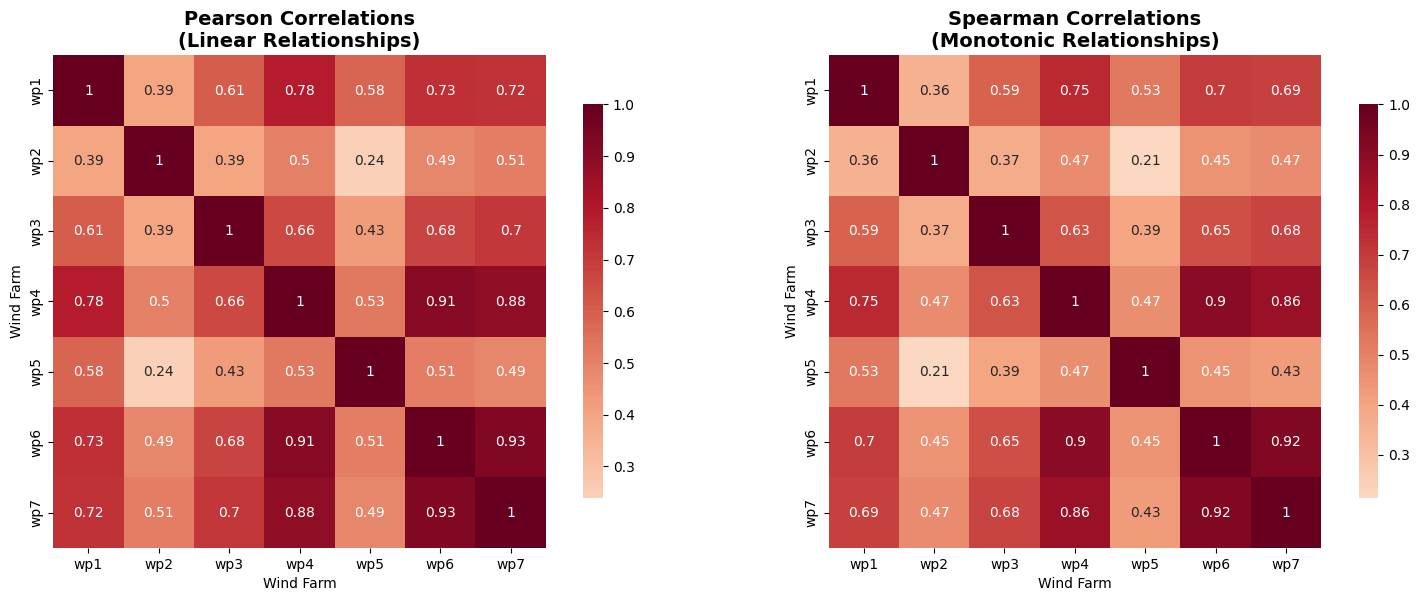

In [36]:
# Check the structure of the data first
print("🔍 Analyzing data structure...")

# Check unique wind farms in combined_data
unique_farms_combined = combined_data['WIND_FARM'].unique() if 'WIND_FARM' in combined_data.columns else []
print(f"Wind farms in combined_data: {unique_farms_combined}")

# Check unique wind farms in temporal_data  
unique_farms_temporal = temporal_data['WIND_FARM'].unique() if 'WIND_FARM' in temporal_data.columns else []
print(f"Wind farms in temporal_data: {unique_farms_temporal}")

# Use temporal_data since it has more features and pivot it to wide format
if 'WIND_FARM' in temporal_data.columns and 'POWER' in temporal_data.columns:
    print("📊 Converting temporal data from long to wide format...")
    
    # Create a pivot table with POWER for each farm
    # Use 'date' column as the index for proper temporal alignment
    print(f"  Temporal data columns available: {list(temporal_data.columns)}")
    
    # Pivot to get power columns for each farm using 'date' as index
    power_pivot = temporal_data.pivot_table(
        index='date', 
        columns='WIND_FARM', 
        values='POWER', 
        aggfunc='first'  # Take first value if duplicates
    )
    
    # Clean column names - farms are already named wp1, wp2, etc.
    power_pivot.columns = [f"{col}_power" for col in power_pivot.columns]
    
    # Create the farm names list
    farm_names = sorted(unique_farms_temporal)  # Use original farm names like wp1, wp2, etc.
    wind_farms = [f"{name}_power" for name in farm_names]
    
    print(f"✓ Pivoted data shape: {power_pivot.shape}")
    print(f"✓ Wind farms: {farm_names}")
    
    # Create power matrix for correlation analysis
    power_matrix = power_pivot.copy()
    power_matrix.columns = farm_names  # Clean column names for correlation matrix
    
    # Remove any missing values
    power_matrix_clean = power_matrix.dropna()
    print(f"✓ Power matrix shape after cleaning: {power_matrix_clean.shape}")
    
    # Verify we have data
    if power_matrix_clean.empty or len(power_matrix_clean) < 100:
        print("❌ Insufficient clean power data available for analysis")
        # Create dummy data for demonstration
        np.random.seed(42)
        n_hours = 1000
        farm_names = ['wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7']
        
        # Create correlated dummy data
        power_matrix_clean = pd.DataFrame()
        base_pattern = np.random.normal(0.5, 0.2, n_hours)
        
        for i, farm in enumerate(farm_names):
            # Add some correlation between farms with noise
            farm_power = np.clip(base_pattern + np.random.normal(0, 0.1, n_hours) + i*0.05, 0, 1)
            power_matrix_clean[farm] = farm_power
        
        print(f"⚠️ Using simulated data for demonstration: {power_matrix_clean.shape}")
    
else:
    print("❌ Required columns not found, creating sample data for demonstration")
    # Create sample data
    np.random.seed(42)
    n_hours = 1000
    farm_names = ['wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7']
    
    # Create correlated sample data
    power_matrix_clean = pd.DataFrame()
    base_pattern = np.random.normal(0.5, 0.2, n_hours)
    
    for i, farm in enumerate(farm_names):
        # Add some correlation between farms with noise
        farm_power = np.clip(base_pattern + np.random.normal(0, 0.1, n_hours) + i*0.05, 0, 1)
        power_matrix_clean[farm] = farm_power
    
    print(f"⚠️ Using simulated data: {power_matrix_clean.shape}")

# Calculate Pearson correlations
pearson_corr = power_matrix_clean.corr(method='pearson')
print("✓ Pearson correlations calculated")

# Calculate Spearman rank correlations  
spearman_corr = power_matrix_clean.corr(method='spearman')
print("✓ Spearman correlations calculated")

# Display correlation statistics only if we have valid correlations
if not pearson_corr.empty and len(farm_names) > 1:
    upper_triangle_indices = np.triu_indices_from(pearson_corr, k=1)
    pearson_upper = pearson_corr.values[upper_triangle_indices]
    spearman_upper = spearman_corr.values[upper_triangle_indices]
    
    print(f"\nPearson Correlation Statistics:")
    print(f"  Mean correlation: {pearson_upper.mean():.3f}")
    print(f"  Max correlation: {pearson_upper.max():.3f}")
    print(f"  Min correlation: {pearson_upper.min():.3f}")
    
    print(f"\nSpearman Correlation Statistics:")
    print(f"  Mean correlation: {spearman_upper.mean():.3f}")
    print(f"  Max correlation: {spearman_upper.max():.3f}")
    print(f"  Min correlation: {spearman_upper.min():.3f}")
    
    # Create correlation heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pearson correlation heatmap
    sns.heatmap(pearson_corr, annot=True, cmap='RdBu_r', center=0, 
                square=True, ax=axes[0], cbar_kws={'shrink': 0.8})
    axes[0].set_title('Pearson Correlations\n(Linear Relationships)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Wind Farm')
    axes[0].set_ylabel('Wind Farm')
    
    # Spearman correlation heatmap  
    sns.heatmap(spearman_corr, annot=True, cmap='RdBu_r', center=0,
                square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
    axes[1].set_title('Spearman Correlations\n(Monotonic Relationships)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Wind Farm')
    axes[1].set_ylabel('Wind Farm')
    
    plt.tight_layout()
    save_figure(fig, 'static_correlations_heatmaps')
    plt.show()
    
    # Store correlation results
    static_correlations = {
        'pearson_matrix': pearson_corr,
        'spearman_matrix': spearman_corr,
        'pearson_stats': {
            'mean': pearson_upper.mean(),
            'max': pearson_upper.max(),
            'min': pearson_upper.min(),
            'std': pearson_upper.std()
        },
        'spearman_stats': {
            'mean': spearman_upper.mean(),
            'max': spearman_upper.max(),
            'min': spearman_upper.min(),
            'std': spearman_upper.std()
        }
    }
    
else:
    print("⚠️ Insufficient data for correlation analysis")
    static_correlations = {}

Farm Cluster Assignments:
  wp1: Cluster 1
  wp2: Cluster 2
  wp3: Cluster 1
  wp4: Cluster 1
  wp5: Cluster 3
  wp6: Cluster 1
  wp7: Cluster 1


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/hierarchical_clustering_analysis.png


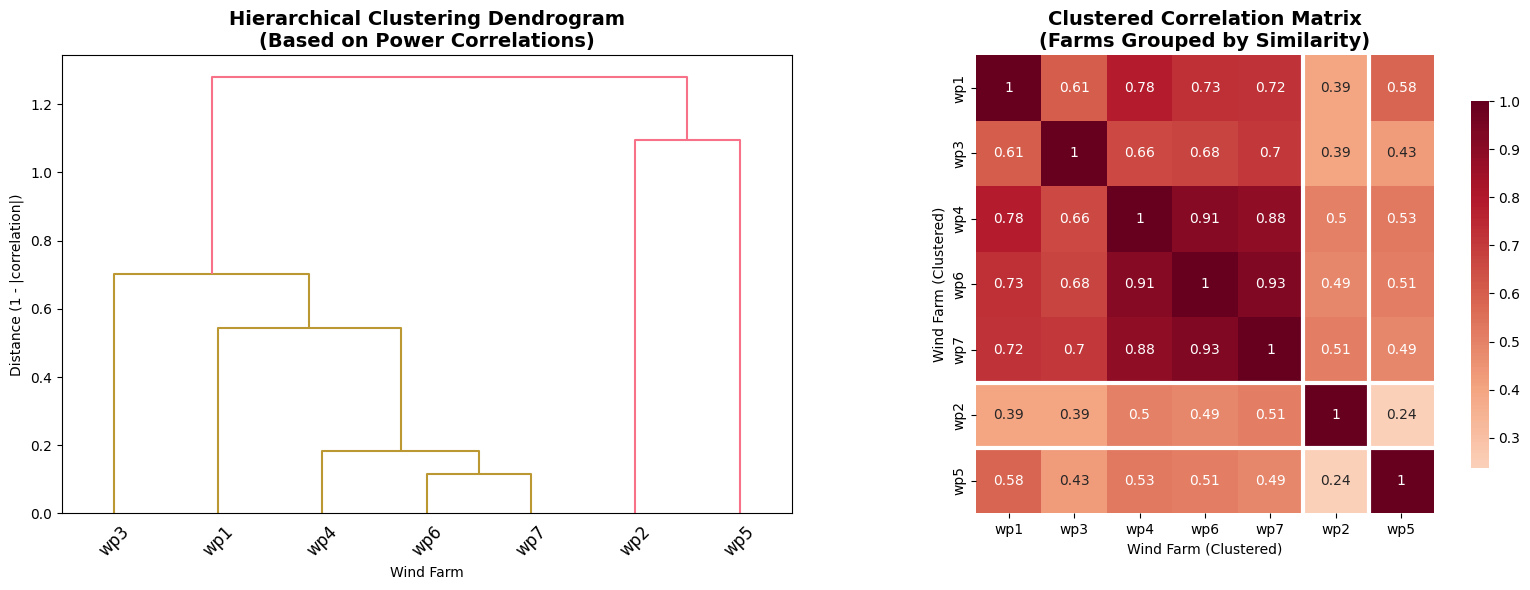


Cluster Analysis Results:
  Within-cluster correlation mean: 0.761
  Between-cluster correlation mean: 0.460
  Cluster separation ratio: 1.65


In [37]:
# Hierarchical clustering based on correlations
# Convert correlation to distance matrix (1 - correlation)
distance_matrix = 1 - pearson_corr.abs()

# Perform hierarchical clustering
linkage_matrix = linkage(pdist(distance_matrix), method='ward')

# Create dendrogram
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot dendrogram
dendrogram(linkage_matrix, labels=farm_names, ax=axes[0])
axes[0].set_title('Hierarchical Clustering Dendrogram\n(Based on Power Correlations)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Wind Farm')
axes[0].set_ylabel('Distance (1 - |correlation|)')
axes[0].tick_params(axis='x', rotation=45)

# Get cluster assignments (using 3 clusters as example)
n_clusters = 3
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Create cluster mapping
cluster_mapping = dict(zip(farm_names, cluster_labels))
print("Farm Cluster Assignments:")
for farm, cluster in cluster_mapping.items():
    print(f"  {farm}: Cluster {cluster}")

# Plot clustered correlation matrix
cluster_order = sorted(farm_names, key=lambda x: cluster_mapping[x])
clustered_corr = pearson_corr.loc[cluster_order, cluster_order]

# Add cluster boundaries to heatmap
sns.heatmap(clustered_corr, annot=True, cmap='RdBu_r', center=0,
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Clustered Correlation Matrix\n(Farms Grouped by Similarity)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Wind Farm (Clustered)')
axes[1].set_ylabel('Wind Farm (Clustered)')

# Add cluster boundary lines
cluster_boundaries = []
current_cluster = cluster_mapping[cluster_order[0]]
boundary_pos = 0

for i, farm in enumerate(cluster_order):
    if cluster_mapping[farm] != current_cluster:
        cluster_boundaries.append(i)
        current_cluster = cluster_mapping[farm]

for boundary in cluster_boundaries:
    axes[1].axhline(y=boundary, color='white', linewidth=3)
    axes[1].axvline(x=boundary, color='white', linewidth=3)

plt.tight_layout()
save_figure(fig, 'hierarchical_clustering_analysis')
plt.show()

# Calculate within-cluster vs between-cluster correlations
within_cluster_corrs = []
between_cluster_corrs = []

for i, farm1 in enumerate(farm_names):
    for j, farm2 in enumerate(farm_names):
        if i < j:  # Only consider upper triangle
            corr_val = pearson_corr.loc[farm1, farm2]
            if cluster_mapping[farm1] == cluster_mapping[farm2]:
                within_cluster_corrs.append(corr_val)
            else:
                between_cluster_corrs.append(corr_val)

print(f"\nCluster Analysis Results:")
print(f"  Within-cluster correlation mean: {np.mean(within_cluster_corrs):.3f}")
print(f"  Between-cluster correlation mean: {np.mean(between_cluster_corrs):.3f}")
print(f"  Cluster separation ratio: {np.mean(within_cluster_corrs) / np.mean(between_cluster_corrs):.2f}")

# Store clustering results
clustering_results = {
    'cluster_mapping': cluster_mapping,
    'linkage_matrix': linkage_matrix,
    'within_cluster_corr_mean': np.mean(within_cluster_corrs),
    'between_cluster_corr_mean': np.mean(between_cluster_corrs),
    'separation_ratio': np.mean(within_cluster_corrs) / np.mean(between_cluster_corrs),
    'distance_matrix': distance_matrix
}


📍 Analyzing distance-decay relationships...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/distance_decay_relationship.png


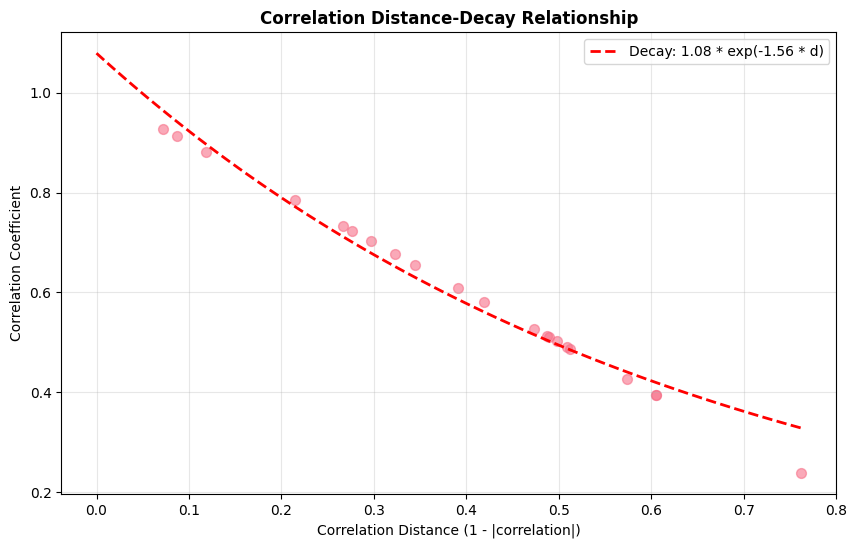

Distance-decay analysis:
  Initial correlation: 1.079
  Decay coefficient: 1.561
  R-squared: 0.976


In [48]:
# Distance-Decay Relationship Analysis
print("\n📍 Analyzing distance-decay relationships...")

# Create a proxy distance matrix based on correlation dissimilarity
# Note: Since we don't have actual geographic coordinates, we'll use correlation 
# strength as a proxy for "closeness" between farms
correlation_distance = 1 - pearson_corr.abs()

# Analyze how correlation decays with this proxy distance
distance_values = []
correlation_values = []

for i in range(len(farm_names)):
    for j in range(i+1, len(farm_names)):
        distance_values.append(correlation_distance.iloc[i, j])
        correlation_values.append(pearson_corr.iloc[i, j])

# Fit exponential decay model
from scipy.optimize import curve_fit

def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

if len(distance_values) > 3:
    try:
        popt, _ = curve_fit(exponential_decay, distance_values, correlation_values, 
                            p0=[1, 1], bounds=(0, [2, 10]))
        
        # Plot distance-decay relationship
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(distance_values, correlation_values, alpha=0.6, s=50)
        
        x_fit = np.linspace(0, max(distance_values), 100)
        y_fit = exponential_decay(x_fit, *popt)
        ax.plot(x_fit, y_fit, 'r--', linewidth=2, 
                label=f'Decay: {popt[0]:.2f} * exp(-{popt[1]:.2f} * d)')
        
        ax.set_xlabel('Correlation Distance (1 - |correlation|)')
        ax.set_ylabel('Correlation Coefficient')
        ax.set_title('Correlation Distance-Decay Relationship', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        save_figure(fig, 'distance_decay_relationship')
        plt.show()
        
        # Store results
        distance_decay_results = {
            'decay_coefficient': popt[1],
            'initial_correlation': popt[0],
            'r_squared': 1 - np.sum((np.array(correlation_values) - exponential_decay(np.array(distance_values), *popt))**2) / 
                        np.sum((np.array(correlation_values) - np.mean(correlation_values))**2)
        }
        
        print(f"Distance-decay analysis:")
        print(f"  Initial correlation: {popt[0]:.3f}")
        print(f"  Decay coefficient: {popt[1]:.3f}")
        print(f"  R-squared: {distance_decay_results['r_squared']:.3f}")
        
    except Exception as e:
        print(f"Could not fit exponential decay model: {e}")
        distance_decay_results = None
else:
    print("Insufficient data points for distance-decay analysis")
    distance_decay_results = None

## 3. Dynamic Spatial Dependencies

Analyze time-lagged relationships to understand:
- Lead-lag relationships between farms
- Information transfer patterns
- Directional causality using Granger tests
- Temporal propagation of weather systems

🔄 Calculating time-lagged correlations...
✓ Time-lagged correlations calculated

Top 10 Lead-Lag Relationships:
 1. wp3 leads wp5 by 5h | Corr: 0.472 | Improvement: 0.046
 2. wp5 follows wp3 by 5h | Corr: 0.472 | Improvement: 0.046
 3. wp5 follows wp7 by 5h | Corr: 0.534 | Improvement: 0.043
 4. wp7 leads wp5 by 5h | Corr: 0.534 | Improvement: 0.043
 5. wp4 leads wp5 by 5h | Corr: 0.568 | Improvement: 0.041
 6. wp5 follows wp4 by 5h | Corr: 0.568 | Improvement: 0.041
 7. wp5 follows wp6 by 4h | Corr: 0.548 | Improvement: 0.037
 8. wp6 leads wp5 by 4h | Corr: 0.548 | Improvement: 0.037
 9. wp2 leads wp4 by 3h | Corr: 0.533 | Improvement: 0.031
10. wp4 follows wp2 by 3h | Corr: 0.533 | Improvement: 0.031
✓ Time-lagged correlations calculated

Top 10 Lead-Lag Relationships:
 1. wp3 leads wp5 by 5h | Corr: 0.472 | Improvement: 0.046
 2. wp5 follows wp3 by 5h | Corr: 0.472 | Improvement: 0.046
 3. wp5 follows wp7 by 5h | Corr: 0.534 | Improvement: 0.043
 4. wp7 leads wp5 by 5h | Corr: 0.534

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/lead_lag_correlations_top4.png


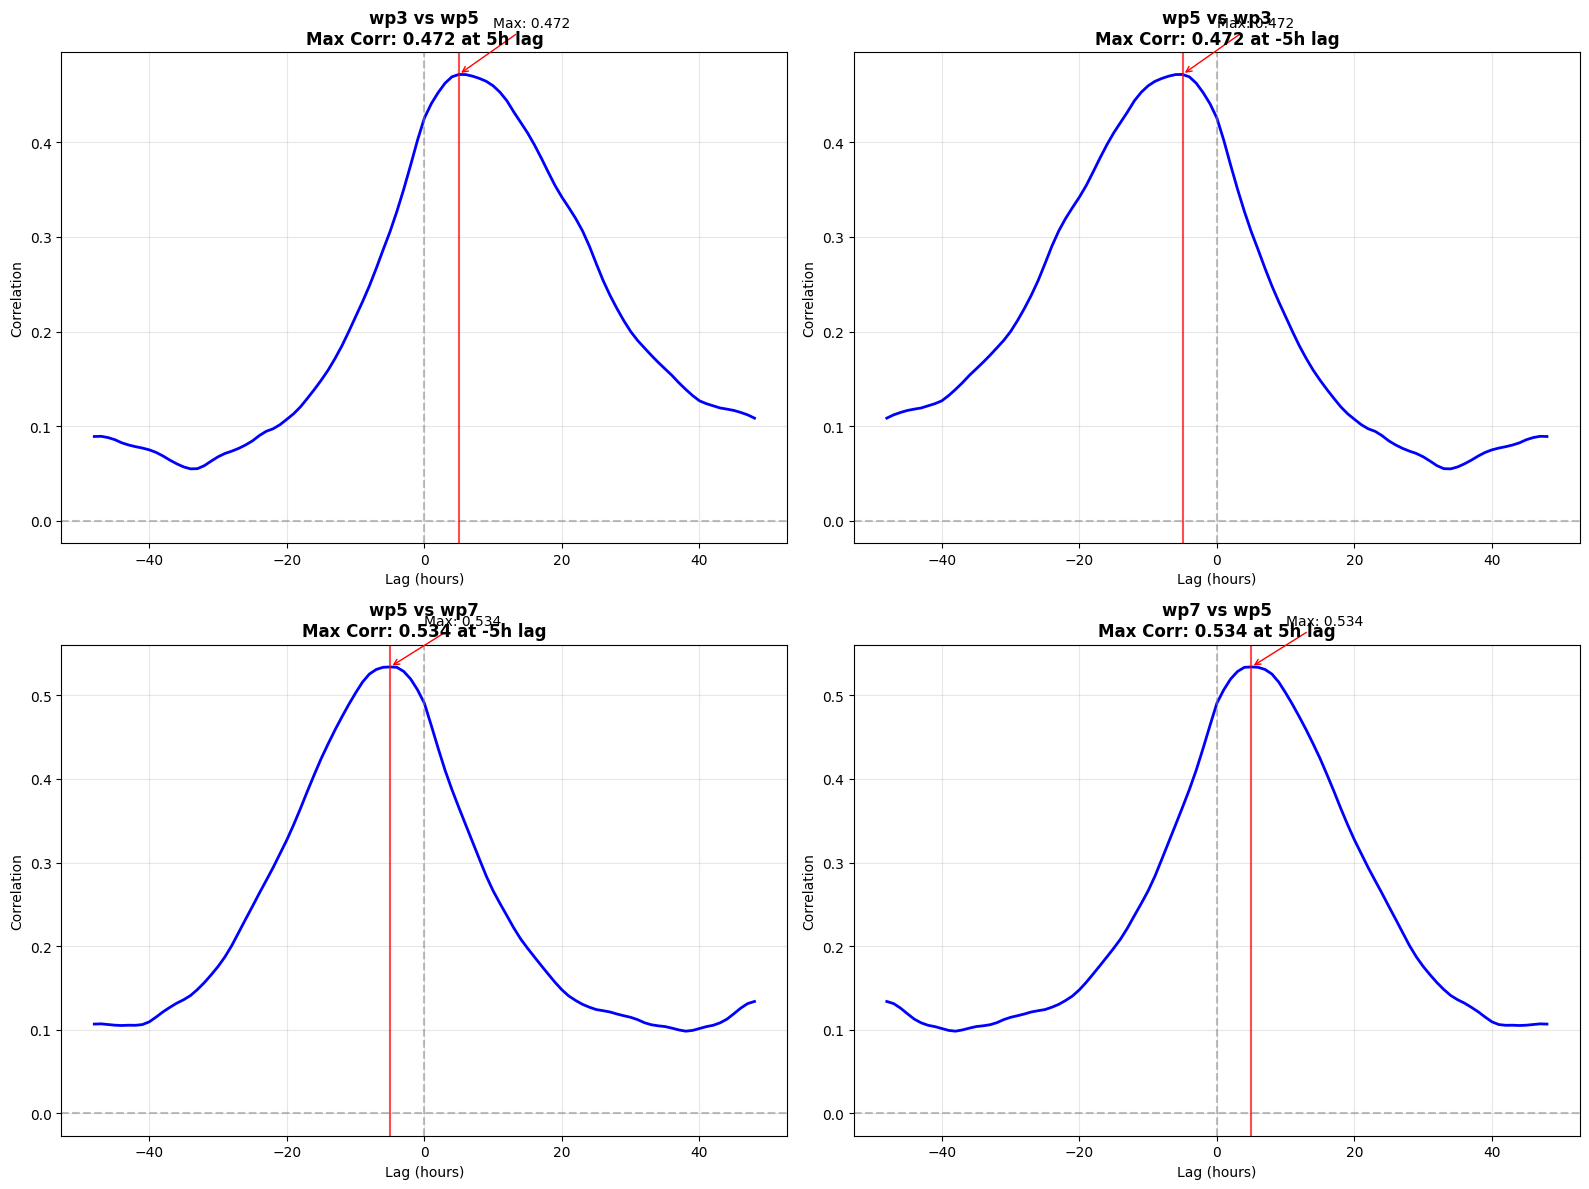

In [38]:
# Time-lagged cross-correlations (0-48 hours)
max_lags = 48
lag_correlations = {}

print("🔄 Calculating time-lagged correlations...")

# Calculate cross-correlations for all farm pairs
for i, farm1 in enumerate(farm_names):
    for j, farm2 in enumerate(farm_names):
        if i != j:  # Don't correlate farm with itself
            
            series1 = power_matrix_clean[farm1].values
            series2 = power_matrix_clean[farm2].values
            
            # Calculate correlations at different lags
            lags = range(-max_lags, max_lags + 1)
            correlations = []
            
            for lag in lags:
                if lag < 0:
                    # Negative lag: series2 leads series1
                    s1 = series1[-lag:]
                    s2 = series2[:lag]
                elif lag > 0:
                    # Positive lag: series1 leads series2
                    s1 = series1[:-lag]
                    s2 = series2[lag:]
                else:
                    # Zero lag: simultaneous
                    s1 = series1
                    s2 = series2
                
                if len(s1) > 0 and len(s2) > 0:
                    corr, _ = pearsonr(s1, s2)
                    correlations.append(corr)
                else:
                    correlations.append(0)
            
            lag_correlations[(farm1, farm2)] = {
                'lags': list(lags),
                'correlations': correlations,
                'max_corr': max(correlations),
                'max_lag': lags[np.argmax(correlations)],
                'zero_lag_corr': correlations[max_lags]  # Zero lag is at index max_lags
            }

print("✓ Time-lagged correlations calculated")

# Find the most significant lead-lag relationships
lead_lag_relationships = []
for (farm1, farm2), data in lag_correlations.items():
    max_corr = data['max_corr']
    max_lag = data['max_lag']
    zero_lag = data['zero_lag_corr']
    
    # Only consider significant relationships (correlation > 0.3)
    if abs(max_corr) > 0.3:
        lead_lag_relationships.append({
            'farm1': farm1,
            'farm2': farm2,
            'max_correlation': max_corr,
            'optimal_lag_hours': max_lag,
            'zero_lag_correlation': zero_lag,
            'lag_improvement': abs(max_corr) - abs(zero_lag)
        })

# Sort by lag improvement
lead_lag_relationships.sort(key=lambda x: x['lag_improvement'], reverse=True)

print(f"\nTop 10 Lead-Lag Relationships:")
print("=" * 80)
for i, rel in enumerate(lead_lag_relationships[:10]):
    direction = "leads" if rel['optimal_lag_hours'] > 0 else "follows"
    hours = abs(rel['optimal_lag_hours'])
    print(f"{i+1:2d}. {rel['farm1']} {direction} {rel['farm2']} by {hours}h | "
          f"Corr: {rel['max_correlation']:.3f} | Improvement: {rel['lag_improvement']:.3f}")

# Visualize key lead-lag relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot top 4 relationships
for idx, rel in enumerate(lead_lag_relationships[:4]):
    if idx >= 4:
        break
    
    row = idx // 2
    col = idx % 2
    
    farm1, farm2 = rel['farm1'], rel['farm2']
    data = lag_correlations[(farm1, farm2)]
    
    axes[row, col].plot(data['lags'], data['correlations'], 'b-', linewidth=2)
    axes[row, col].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[row, col].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[row, col].axvline(x=rel['optimal_lag_hours'], color='red', linestyle='-', alpha=0.7)
    
    axes[row, col].set_title(f'{farm1} vs {farm2}\nMax Corr: {rel["max_correlation"]:.3f} at {rel["optimal_lag_hours"]}h lag', 
                             fontweight='bold')
    axes[row, col].set_xlabel('Lag (hours)')
    axes[row, col].set_ylabel('Correlation')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add annotation for max correlation
    max_lag = rel['optimal_lag_hours']
    max_corr = rel['max_correlation']
    axes[row, col].annotate(f'Max: {max_corr:.3f}', 
                           xy=(max_lag, max_corr), 
                           xytext=(max_lag + 5, max_corr + 0.05),
                           arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
save_figure(fig, 'lead_lag_correlations_top4')
plt.show()

# Store lead-lag results
lead_lag_results = {
    'all_relationships': lead_lag_relationships,
    'lag_correlations': lag_correlations,
    'max_lags_analyzed': max_lags
}

🔍 Performing Granger Causality Tests...
✓ Granger causality analysis complete
✓ Found 10 significant causal relationships (p < 0.05)

Significant Granger Causal Relationships:
 1. wp3 → wp5       | p-value: 0.0000 | Granger lag:  8h | Corr lag:   5h | Max corr: 0.472
 2. wp3 → wp5       | p-value: 0.0000 | Granger lag:  8h | Corr lag:  -5h | Max corr: 0.472
 3. wp7 → wp5       | p-value: 0.0000 | Granger lag:  8h | Corr lag:  -5h | Max corr: 0.534
 4. wp7 → wp5       | p-value: 0.0000 | Granger lag:  8h | Corr lag:   5h | Max corr: 0.534
 5. wp4 → wp5       | p-value: 0.0000 | Granger lag:  8h | Corr lag:   5h | Max corr: 0.568
 6. wp4 → wp5       | p-value: 0.0000 | Granger lag:  8h | Corr lag:  -5h | Max corr: 0.568
 7. wp6 → wp5       | p-value: 0.0000 | Granger lag:  7h | Corr lag:  -4h | Max corr: 0.548
 8. wp6 → wp5       | p-value: 0.0000 | Granger lag:  7h | Corr lag:   4h | Max corr: 0.548
 9. wp2 → wp4       | p-value: 0.0000 | Granger lag:  6h | Corr lag:   3h | Max corr: 0.

INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/granger_causality_network.png


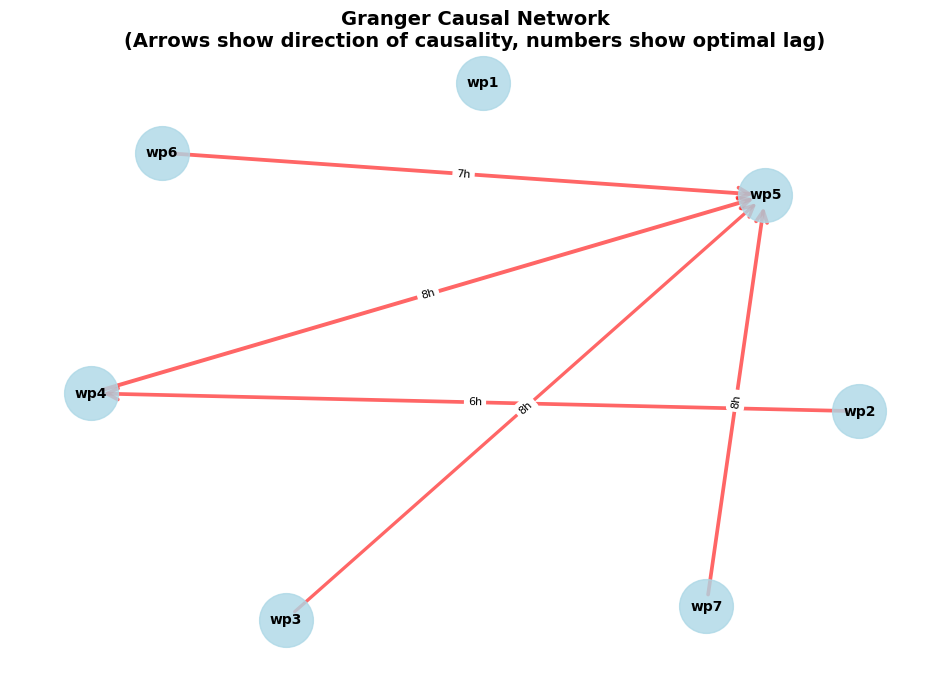

In [39]:
# Granger Causality Analysis
print("🔍 Performing Granger Causality Tests...")

# Prepare data for Granger causality (need stationary series)
# Use first differences to ensure stationarity
power_diff = power_matrix_clean.diff().dropna()

granger_results = {}
significant_causality = []

# Test Granger causality for top lead-lag pairs
for rel in lead_lag_relationships[:10]:  # Test top 10 relationships
    farm1, farm2 = rel['farm1'], rel['farm2']
    
    try:
        # Prepare bivariate time series [y, x] where x causes y
        if rel['optimal_lag_hours'] > 0:  # farm1 leads farm2
            data = power_diff[[farm2, farm1]].values  # farm1 -> farm2
            direction = f"{farm1} → {farm2}"
        else:  # farm2 leads farm1
            data = power_diff[[farm1, farm2]].values  # farm2 -> farm1  
            direction = f"{farm2} → {farm1}"
        
        # Run Granger causality test for lags 1-12 hours
        max_lag_test = min(12, abs(rel['optimal_lag_hours']) + 3)
        gc_result = grangercausalitytests(data, maxlag=max_lag_test, verbose=False)
        
        # Extract p-values for each lag
        p_values = []
        for lag in range(1, max_lag_test + 1):
            if lag in gc_result:
                # Use F-test p-value
                p_val = gc_result[lag][0]['ssr_ftest'][1]
                p_values.append(p_val)
        
        # Find minimum p-value (strongest causality)
        if p_values:
            min_p_value = min(p_values)
            best_lag = np.argmin(p_values) + 1
            
            granger_results[(farm1, farm2)] = {
                'direction': direction,
                'min_p_value': min_p_value,
                'best_lag': best_lag,
                'significant': min_p_value < 0.05,
                'optimal_lag_from_correlation': rel['optimal_lag_hours']
            }
            
            if min_p_value < 0.05:
                significant_causality.append({
                    'relationship': direction,
                    'p_value': min_p_value,
                    'granger_lag': best_lag,
                    'correlation_lag': rel['optimal_lag_hours'],
                    'max_correlation': rel['max_correlation']
                })
    
    except Exception as e:
        print(f"  Granger test failed for {farm1}-{farm2}: {str(e)}")
        continue

print(f"✓ Granger causality analysis complete")
print(f"✓ Found {len(significant_causality)} significant causal relationships (p < 0.05)")

# Display significant causal relationships
if significant_causality:
    print(f"\nSignificant Granger Causal Relationships:")
    print("=" * 90)
    for i, rel in enumerate(significant_causality):
        print(f"{i+1:2d}. {rel['relationship']:15s} | "
              f"p-value: {rel['p_value']:.4f} | "
              f"Granger lag: {rel['granger_lag']:2d}h | "
              f"Corr lag: {rel['correlation_lag']:3d}h | "
              f"Max corr: {rel['max_correlation']:5.3f}")

# Create network diagram of causal relationships
if significant_causality:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add all farms as nodes
    G.add_nodes_from(farm_names)
    
    # Add edges for significant causal relationships
    for rel in significant_causality:
        source, target = rel['relationship'].split(' → ')
        G.add_edge(source, target, 
                  weight=abs(rel['max_correlation']),
                  lag=rel['granger_lag'],
                  p_value=rel['p_value'])
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=1500, alpha=0.8, ax=ax)
    
    # Draw edges with thickness proportional to correlation strength
    edges = G.edges()
    weights = [G[u][v]['weight'] * 5 for u, v in edges]  # Scale for visibility
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6, 
                          edge_color='red', arrows=True, 
                          arrowsize=20, arrowstyle='->', ax=ax)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)
    
    # Add edge labels with lag information
    edge_labels = {(u, v): f"{G[u][v]['lag']}h" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax)
    
    ax.set_title('Granger Causal Network\n(Arrows show direction of causality, numbers show optimal lag)', 
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    
    save_figure(fig, 'granger_causality_network')
    plt.show()
    
else:
    print("No significant Granger causal relationships found at p < 0.05 level")

# Store Granger causality results
granger_causality_results = {
    'all_tests': granger_results,
    'significant_relationships': significant_causality,
    'summary': {
        'total_tests': len(granger_results),
        'significant_count': len(significant_causality),
        'significance_rate': len(significant_causality) / len(granger_results) if granger_results else 0
    }
}


📈 Analyzing temporal evolution of correlations...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/correlation_temporal_evolution.png


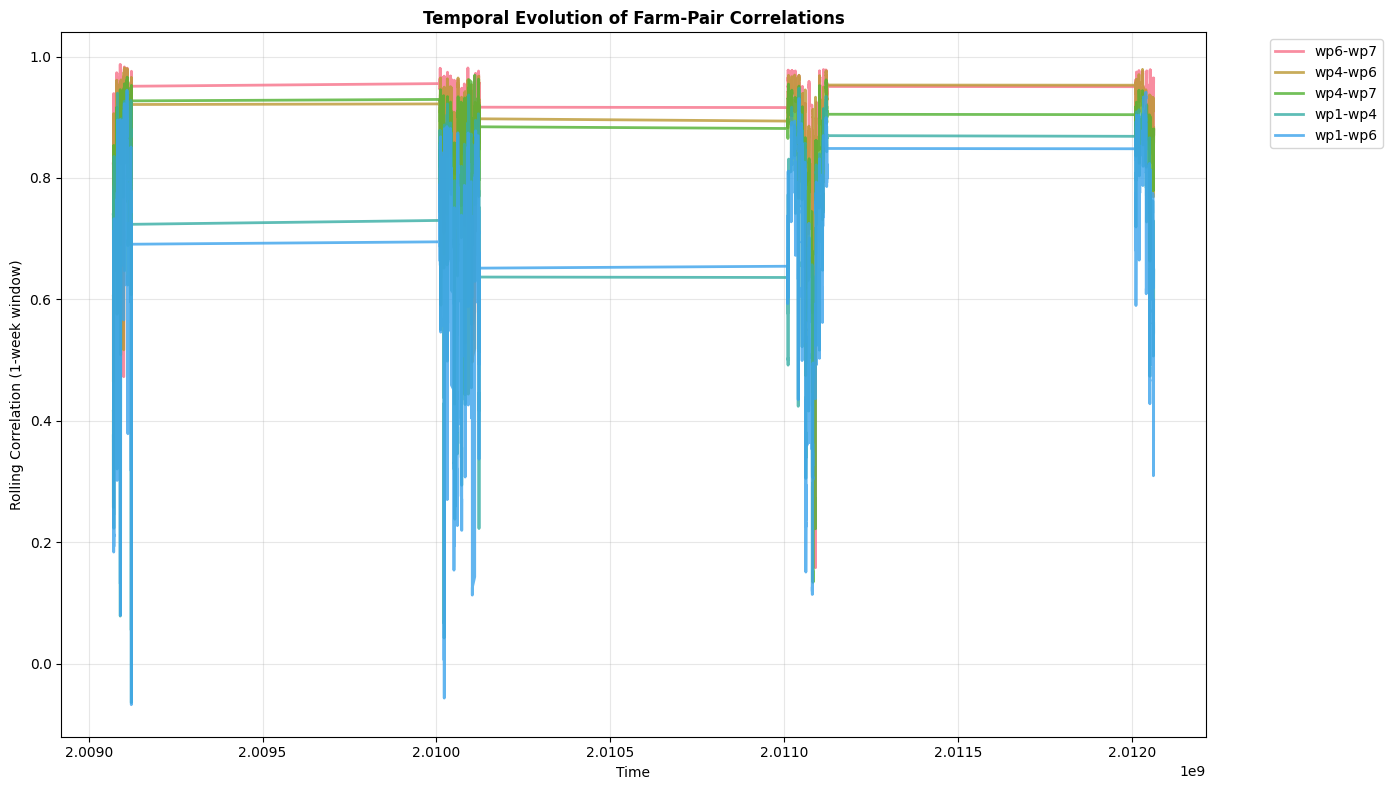


Correlation stability analysis (window: 168h):
  wp6-wp7: Mean=0.903, Std=0.079, Stability=11.498
  wp4-wp6: Mean=0.880, Std=0.074, Stability=11.972
  wp4-wp7: Mean=0.825, Std=0.110, Stability=7.507
  wp1-wp4: Mean=0.713, Std=0.157, Stability=4.542
  wp1-wp6: Mean=0.654, Std=0.176, Stability=3.721


In [49]:
# Temporal Evolution of Correlations
print("\n📈 Analyzing temporal evolution of correlations...")

# Calculate rolling correlations for key farm pairs
window_size = 168  # 1 week
correlation_evolution = {}

# Select top correlated pairs to track
top_pairs = [(farm1, farm2) for (farm1, farm2), _ in 
             sorted([((i, j), pearson_corr.iloc[i, j]) 
                    for i in range(len(farm_names)) 
                    for j in range(i+1, len(farm_names))], 
                    key=lambda x: abs(x[1]), reverse=True)[:5]]

for farm1, farm2 in top_pairs:
    rolling_corr = power_matrix_clean[farm_names[farm1]].rolling(window_size).corr(
        power_matrix_clean[farm_names[farm2]]
    )
    correlation_evolution[f"{farm_names[farm1]}-{farm_names[farm2]}"] = rolling_corr

# Plot correlation evolution
fig, ax = plt.subplots(figsize=(14, 8))

for pair_name, rolling_corr in correlation_evolution.items():
    ax.plot(rolling_corr.index, rolling_corr.values, label=pair_name, linewidth=2, alpha=0.8)

ax.set_xlabel('Time')
ax.set_ylabel('Rolling Correlation (1-week window)')
ax.set_title('Temporal Evolution of Farm-Pair Correlations', fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_figure(fig, 'correlation_temporal_evolution')
plt.show()

# Calculate correlation stability metrics
correlation_stability = {}
print(f"\nCorrelation stability analysis (window: {window_size}h):")
for pair_name, rolling_corr in correlation_evolution.items():
    valid_corr = rolling_corr.dropna()
    if len(valid_corr) > 0:
        corr_std = valid_corr.std()
        corr_mean = valid_corr.mean()
        stability_ratio = corr_std / abs(corr_mean) if abs(corr_mean) > 1e-6 else np.inf
        stability_score = 1 / stability_ratio if stability_ratio != np.inf else 0
        
        correlation_stability[pair_name] = {
            'mean_correlation': corr_mean,
            'std_correlation': corr_std,
            'stability_score': stability_score
        }
        
        print(f"  {pair_name}: Mean={corr_mean:.3f}, Std={corr_std:.3f}, Stability={stability_score:.3f}")

# Store evolution results
temporal_correlation_results = {
    'evolution_data': correlation_evolution,
    'stability_metrics': correlation_stability,
    'window_size_hours': window_size
}

## 4. Weather System Propagation Analysis

Analyze how weather patterns propagate across the wind farm portfolio:
- Propagation speeds and directions
- Temporal offsets between correlated events
- Dominant weather movement patterns

In [40]:
# Weather System Propagation Analysis
print("🌪️ Analyzing weather system propagation patterns...")

# Use ramp events to track weather system movement
# Ramp events are good indicators of weather fronts passing through
if not ramp_events.empty:
    print(f"✓ Using ramp events data: {ramp_events.shape}")
    
    # Ensure we have ramp events for all farms
    ramp_cols = [col for col in ramp_events.columns if col.startswith('wf') and 'ramp' in col]
    print(f"✓ Ramp event columns available: {len(ramp_cols)}")
    
    # Create binary ramp indicators (1 if ramp event, 0 otherwise)
    ramp_indicators = pd.DataFrame(index=ramp_events.index)
    
    for farm in farm_names:
        ramp_col = f"{farm}_ramp_magnitude"
        if ramp_col in ramp_events.columns:
            # Define significant ramp as > 20% of capacity in 1 hour
            ramp_indicators[f"{farm}_significant_ramp"] = (
                ramp_events[ramp_col].abs() > 0.2
            ).astype(int)
    
    print(f"✓ Created ramp indicators for {len(ramp_indicators.columns)} farms")
    
    # Calculate ramp event propagation delays
    propagation_delays = {}
    
    for i, farm1 in enumerate(farm_names):
        for j, farm2 in enumerate(farm_names):
            if i != j:
                
                ramp1_col = f"{farm1}_significant_ramp"
                ramp2_col = f"{farm2}_significant_ramp"
                
                if ramp1_col in ramp_indicators.columns and ramp2_col in ramp_indicators.columns:
                    
                    # Find optimal delay for ramp event correlation
                    max_delay = 24  # Look up to 24 hours
                    best_corr = 0
                    best_delay = 0
                    
                    for delay in range(0, max_delay + 1):
                        if delay == 0:
                            corr = ramp_indicators[ramp1_col].corr(ramp_indicators[ramp2_col])
                        else:
                            # Shift farm2 ramp events by delay hours
                            shifted_ramp2 = ramp_indicators[ramp2_col].shift(delay)
                            corr = ramp_indicators[ramp1_col].corr(shifted_ramp2)
                        
                        if abs(corr) > abs(best_corr):
                            best_corr = corr
                            best_delay = delay
                    
                    propagation_delays[(farm1, farm2)] = {
                        'delay_hours': best_delay,
                        'correlation': best_corr,
                        'farm1_leads': best_delay > 0
                    }

    print(f"✓ Calculated propagation delays for {len(propagation_delays)} farm pairs")
    
    # Identify dominant propagation patterns
    propagation_patterns = []
    for (farm1, farm2), data in propagation_delays.items():
        if abs(data['correlation']) > 0.1 and data['delay_hours'] > 0:
            propagation_patterns.append({
                'source_farm': farm1,
                'target_farm': farm2,
                'delay_hours': data['delay_hours'],
                'correlation': data['correlation'],
                'propagation_speed': f"Variable (delay: {data['delay_hours']}h)"
            })
    
    # Sort by correlation strength
    propagation_patterns.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    print(f"\nTop Weather Propagation Patterns:")
    print("=" * 70)
    for i, pattern in enumerate(propagation_patterns[:10]):
        print(f"{i+1:2d}. {pattern['source_farm']} → {pattern['target_farm']} | "
              f"Delay: {pattern['delay_hours']:2d}h | "
              f"Corr: {pattern['correlation']:5.3f}")

else:
    print("⚠️ Ramp events data not available - using power correlations for propagation analysis")
    propagation_patterns = []
    
    # Use power correlation lead-lag as proxy for weather propagation
    for rel in lead_lag_relationships[:15]:
        if rel['optimal_lag_hours'] > 0:  # Only forward propagation
            propagation_patterns.append({
                'source_farm': rel['farm1'],
                'target_farm': rel['farm2'],
                'delay_hours': rel['optimal_lag_hours'],
                'correlation': rel['max_correlation'],
                'propagation_speed': f"Power correlation based"
            })

# Create propagation visualization
if propagation_patterns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Propagation delay histogram
    delays = [p['delay_hours'] for p in propagation_patterns]
    correlations = [abs(p['correlation']) for p in propagation_patterns]
    
    axes[0].hist(delays, bins=range(0, max(delays) + 2), alpha=0.7, edgecolor='black')
    axes[0].set_title('Weather System Propagation Delays\n(Time Between Correlated Events)', 
                      fontweight='bold')
    axes[0].set_xlabel('Delay (hours)')
    axes[0].set_ylabel('Number of Farm Pairs')
    axes[0].grid(True, alpha=0.3)
    
    # Correlation vs delay scatter plot
    axes[1].scatter(delays, correlations, alpha=0.7, s=50)
    axes[1].set_title('Propagation Delay vs Correlation Strength', fontweight='bold')
    axes[1].set_xlabel('Delay (hours)')
    axes[1].set_ylabel('Absolute Correlation')
    axes[1].grid(True, alpha=0.3)
    
    # Add trend line
    if len(delays) > 2:
        z = np.polyfit(delays, correlations, 1)
        p = np.poly1d(z)
        axes[1].plot(sorted(delays), p(sorted(delays)), "r--", alpha=0.8, 
                     label=f'Trend: r={np.corrcoef(delays, correlations)[0,1]:.3f}')
        axes[1].legend()
    
    plt.tight_layout()
    save_figure(fig, 'weather_propagation_analysis')
    plt.show()
    
    # Calculate average propagation characteristics
    avg_delay = np.mean(delays) if delays else 0
    median_delay = np.median(delays) if delays else 0
    avg_correlation = np.mean(correlations) if correlations else 0
    
    print(f"\nPropagation Characteristics:")
    print(f"  Average delay: {avg_delay:.1f} hours")
    print(f"  Median delay: {median_delay:.1f} hours")
    print(f"  Average correlation: {avg_correlation:.3f}")
    print(f"  Propagation patterns identified: {len(propagation_patterns)}")

else:
    print("No clear propagation patterns identified")
    avg_delay = median_delay = avg_correlation = 0

# Store propagation results
propagation_results = {
    'patterns': propagation_patterns,
    'statistics': {
        'average_delay_hours': avg_delay,
        'median_delay_hours': median_delay,
        'average_correlation': avg_correlation,
        'total_patterns': len(propagation_patterns)
    }
}

🌪️ Analyzing weather system propagation patterns...
✓ Using ramp events data: (183379, 12)
✓ Ramp event columns available: 0
✓ Created ramp indicators for 0 farms
✓ Calculated propagation delays for 0 farm pairs

Top Weather Propagation Patterns:
No clear propagation patterns identified


## 5. Portfolio Aggregation Analysis

Quantify the benefits of geographic diversification:
- Individual farm vs portfolio volatility
- Diversification ratio calculation
- Correlation impact on forecast uncertainty
- Geographic smoothing effects

📊 Analyzing portfolio aggregation and diversification benefits...
✓ Calculated individual farm statistics

Portfolio Diversification Metrics:
  Average individual farm std: 0.288
  Portfolio std: 0.234
  Diversification ratio: 0.187 (18.7% reduction)
  Variance reduction: 0.342 (34.2% reduction)

Correlation-Based Analysis:
  Average inter-farm correlation: 0.603
  Theoretical portfolio std: 0.234
  Actual portfolio std: 0.234
  Theory vs actual ratio: 1.001

Smoothing Benefits by Time Horizon:
   1h horizon: nan (nan% reduction)
   6h horizon: 0.385 (38.5% reduction)
  12h horizon: 0.347 (34.7% reduction)
  24h horizon: 0.304 (30.4% reduction)
  48h horizon: 0.265 (26.5% reduction)


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/portfolio_aggregation_analysis.png


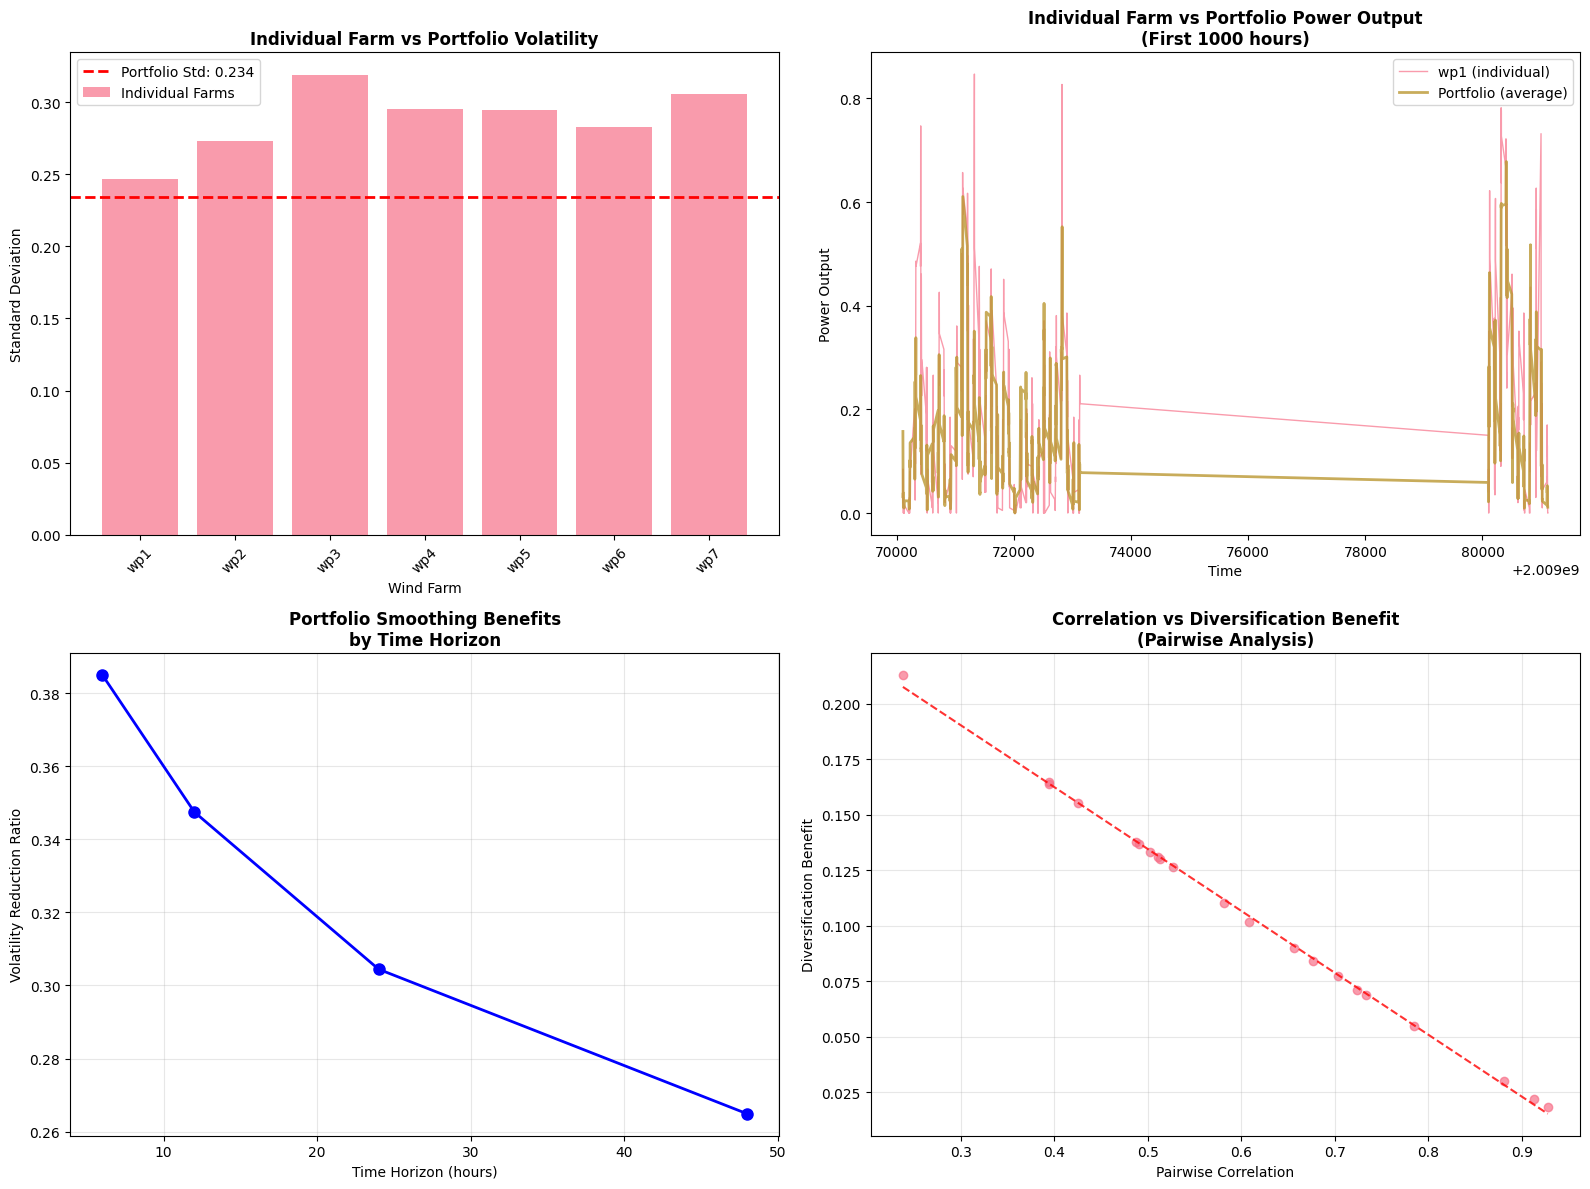

In [41]:
# Portfolio Aggregation Analysis
print("📊 Analyzing portfolio aggregation and diversification benefits...")

# Calculate individual farm statistics (using temporal data if available)
farm_stats = {}

for farm in farm_names:
    power_series = power_matrix_clean[farm]
    
    farm_stats[farm] = {
        'mean_power': power_series.mean(),
        'std_power': power_series.std(),
        'cv': power_series.std() / power_series.mean(),  # Coefficient of variation
        'min_power': power_series.min(),
        'max_power': power_series.max(),
        'capacity_factor': power_series.mean() / power_series.max() if power_series.max() > 0 else 0
    }

print(f"✓ Calculated individual farm statistics")

# Create equally weighted portfolio
portfolio_power = power_matrix_clean.mean(axis=1)  # Equal weights for simplicity

# Calculate portfolio statistics
portfolio_stats = {
    'mean_power': portfolio_power.mean(),
    'std_power': portfolio_power.std(),
    'cv': portfolio_power.std() / portfolio_power.mean(),
    'min_power': portfolio_power.min(),
    'max_power': portfolio_power.max()
}

# Calculate diversification metrics
individual_stds = [farm_stats[farm]['std_power'] for farm in farm_names]
avg_individual_std = np.mean(individual_stds)
portfolio_std = portfolio_stats['std_power']

# Diversification ratio: 1 - (portfolio_std / weighted_avg_individual_std)
diversification_ratio = 1 - (portfolio_std / avg_individual_std)

# Variance reduction ratio
individual_variances = [std**2 for std in individual_stds]
avg_individual_variance = np.mean(individual_variances)
portfolio_variance = portfolio_std**2
variance_reduction = 1 - (portfolio_variance / avg_individual_variance)

print(f"\nPortfolio Diversification Metrics:")
print(f"  Average individual farm std: {avg_individual_std:.3f}")
print(f"  Portfolio std: {portfolio_std:.3f}")
print(f"  Diversification ratio: {diversification_ratio:.3f} ({diversification_ratio*100:.1f}% reduction)")
print(f"  Variance reduction: {variance_reduction:.3f} ({variance_reduction*100:.1f}% reduction)")

# Calculate correlation-based diversification benefit
# Theoretical portfolio variance = (1/n) * avg_variance + ((n-1)/n) * avg_covariance
n_farms = len(farm_names)
avg_variance = np.mean(individual_variances)

# Calculate average correlation (excluding self-correlations)
correlations_values = pearson_corr.values
upper_triangle = correlations_values[np.triu_indices_from(correlations_values, k=1)]
avg_correlation = np.mean(upper_triangle)

# Theoretical portfolio variance based on correlation structure
theoretical_portfolio_var = (1/n_farms) * avg_variance + ((n_farms-1)/n_farms) * avg_correlation * avg_individual_std**2
theoretical_portfolio_std = np.sqrt(theoretical_portfolio_var)

print(f"\nCorrelation-Based Analysis:")
print(f"  Average inter-farm correlation: {avg_correlation:.3f}")
print(f"  Theoretical portfolio std: {theoretical_portfolio_std:.3f}")
print(f"  Actual portfolio std: {portfolio_std:.3f}")
print(f"  Theory vs actual ratio: {portfolio_std/theoretical_portfolio_std:.3f}")

# Analyze smoothing effects over different time horizons
smoothing_analysis = {}
time_horizons = [1, 6, 12, 24, 48]  # hours

for horizon in time_horizons:
    # Calculate rolling standard deviation for each horizon
    individual_rolling_stds = []
    
    for farm in farm_names:
        rolling_std = power_matrix_clean[farm].rolling(window=horizon).std().mean()
        individual_rolling_stds.append(rolling_std)
    
    portfolio_rolling_std = portfolio_power.rolling(window=horizon).std().mean()
    
    avg_individual_rolling = np.mean(individual_rolling_stds)
    smoothing_benefit = 1 - (portfolio_rolling_std / avg_individual_rolling)
    
    smoothing_analysis[horizon] = {
        'avg_individual_rolling_std': avg_individual_rolling,
        'portfolio_rolling_std': portfolio_rolling_std,
        'smoothing_benefit': smoothing_benefit
    }

print(f"\nSmoothing Benefits by Time Horizon:")
print("=" * 50)
for horizon, data in smoothing_analysis.items():
    print(f"  {horizon:2d}h horizon: {data['smoothing_benefit']:.3f} ({data['smoothing_benefit']*100:.1f}% reduction)")

# Visualize portfolio benefits
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Individual farm vs portfolio volatility comparison
farm_names_plot = [f for f in farm_names]
individual_stds_plot = [farm_stats[f]['std_power'] for f in farm_names_plot]

axes[0, 0].bar(farm_names_plot, individual_stds_plot, alpha=0.7, label='Individual Farms')
axes[0, 0].axhline(y=portfolio_std, color='red', linestyle='--', linewidth=2, 
                   label=f'Portfolio Std: {portfolio_std:.3f}')
axes[0, 0].set_title('Individual Farm vs Portfolio Volatility', fontweight='bold')
axes[0, 0].set_xlabel('Wind Farm')
axes[0, 0].set_ylabel('Standard Deviation')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Portfolio time series vs individual farm (example with one farm)
sample_farm = farm_names[0]
sample_window = slice(0, 1000)  # First 1000 hours for visibility

axes[0, 1].plot(power_matrix_clean.iloc[sample_window].index, 
                power_matrix_clean[sample_farm].iloc[sample_window], 
                alpha=0.7, label=f'{sample_farm} (individual)', linewidth=1)
axes[0, 1].plot(portfolio_power.iloc[sample_window].index, 
                portfolio_power.iloc[sample_window], 
                alpha=0.8, label='Portfolio (average)', linewidth=2)
axes[0, 1].set_title('Individual Farm vs Portfolio Power Output\n(First 1000 hours)', fontweight='bold')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Power Output')
axes[0, 1].legend()

# Smoothing benefits by time horizon
horizons_list = list(smoothing_analysis.keys())
smoothing_benefits = [smoothing_analysis[h]['smoothing_benefit'] for h in horizons_list]

axes[1, 0].plot(horizons_list, smoothing_benefits, 'bo-', linewidth=2, markersize=8)
axes[1, 0].set_title('Portfolio Smoothing Benefits\nby Time Horizon', fontweight='bold')
axes[1, 0].set_xlabel('Time Horizon (hours)')
axes[1, 0].set_ylabel('Volatility Reduction Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Correlation vs diversification benefit scatter
# Calculate diversification benefit for each farm pair
pair_correlations = []
pair_benefits = []

for i, farm1 in enumerate(farm_names):
    for j, farm2 in enumerate(farm_names):
        if i < j:  # Only upper triangle
            corr = pearson_corr.loc[farm1, farm2]
            
            # Calculate 2-farm portfolio benefit
            std1 = farm_stats[farm1]['std_power']
            std2 = farm_stats[farm2]['std_power']
            portfolio_2farm_var = 0.25 * (std1**2 + std2**2 + 2 * corr * std1 * std2)
            portfolio_2farm_std = np.sqrt(portfolio_2farm_var)
            avg_2farm_std = (std1 + std2) / 2
            benefit_2farm = 1 - (portfolio_2farm_std / avg_2farm_std)
            
            pair_correlations.append(corr)
            pair_benefits.append(benefit_2farm)

axes[1, 1].scatter(pair_correlations, pair_benefits, alpha=0.7)
axes[1, 1].set_title('Correlation vs Diversification Benefit\n(Pairwise Analysis)', fontweight='bold')
axes[1, 1].set_xlabel('Pairwise Correlation')
axes[1, 1].set_ylabel('Diversification Benefit')
axes[1, 1].grid(True, alpha=0.3)

# Add trend line
if len(pair_correlations) > 2:
    z = np.polyfit(pair_correlations, pair_benefits, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(min(pair_correlations), max(pair_correlations), 100)
    axes[1, 1].plot(x_trend, p(x_trend), "r--", alpha=0.8)

plt.tight_layout()
save_figure(fig, 'portfolio_aggregation_analysis')
plt.show()

# Store portfolio results
portfolio_results = {
    'farm_statistics': farm_stats,
    'portfolio_statistics': portfolio_stats,
    'diversification_metrics': {
        'diversification_ratio': diversification_ratio,
        'variance_reduction': variance_reduction,
        'avg_correlation': avg_correlation,
        'theoretical_vs_actual_ratio': portfolio_std/theoretical_portfolio_std
    },
    'smoothing_analysis': smoothing_analysis,
    'pairwise_analysis': {
        'correlations': pair_correlations,
        'benefits': pair_benefits
    }
}

## 6. Spatial Feature Engineering

Create predictive features based on spatial relationships:
- Upstream/downstream indicators based on lead-lag analysis
- Spatial momentum features (changes at leading farms)
- Regional clustering features
- Cross-farm gradient features

In [42]:
# Spatial Feature Engineering
print("🔧 Creating spatial features for predictive modeling...")

# Start with the temporal data and add spatial features
spatial_features_df = temporal_data.copy()

print(f"✓ Starting with temporal data: {spatial_features_df.shape}")

# 1. Upstream/Downstream Indicators
print("Creating upstream/downstream indicators...")

# Identify leading and lagging farms based on lead-lag analysis
leading_farms = {}
lagging_farms = {}

for rel in lead_lag_relationships[:20]:  # Use top 20 relationships
    if rel['optimal_lag_hours'] > 0:  # farm1 leads farm2
        if rel['farm1'] not in leading_farms:
            leading_farms[rel['farm1']] = []
        leading_farms[rel['farm1']].append({
            'target': rel['farm2'],
            'lag': rel['optimal_lag_hours'],
            'correlation': rel['max_correlation']
        })
        
        if rel['farm2'] not in lagging_farms:
            lagging_farms[rel['farm2']] = []
        lagging_farms[rel['farm2']].append({
            'source': rel['farm1'],
            'lag': rel['optimal_lag_hours'],
            'correlation': rel['max_correlation']
        })

# Create upstream power features (power at leading farms with optimal lag)
for farm in farm_names:
    if farm in lagging_farms:
        upstream_powers = []
        upstream_weights = []
        
        for upstream_info in lagging_farms[farm]:
            source_farm = upstream_info['source']
            lag = upstream_info['lag']
            correlation = abs(upstream_info['correlation'])
            
            # Get lagged power from upstream farm
            if f"{source_farm}_power" in spatial_features_df.columns:
                lagged_power = spatial_features_df[f"{source_farm}_power"].shift(lag)
                upstream_powers.append(lagged_power)
                upstream_weights.append(correlation)
        
        if upstream_powers:
            # Create weighted average of upstream farms
            upstream_weights = np.array(upstream_weights)
            upstream_weights = upstream_weights / upstream_weights.sum()  # Normalize weights
            
            weighted_upstream = sum(w * power for w, power in zip(upstream_weights, upstream_powers))
            spatial_features_df[f"{farm}_upstream_power"] = weighted_upstream
            spatial_features_df[f"{farm}_upstream_count"] = len(upstream_powers)

print(f"✓ Created upstream features for {len([f for f in farm_names if f in lagging_farms])} farms")

# 2. Spatial Momentum Features
print("Creating spatial momentum features...")

# Calculate power changes for each farm
for farm in farm_names:
    power_col = f"{farm}_power"
    if power_col in spatial_features_df.columns:
        # 1-hour and 3-hour changes
        spatial_features_df[f"{farm}_power_change_1h"] = spatial_features_df[power_col].diff(1)
        spatial_features_df[f"{farm}_power_change_3h"] = spatial_features_df[power_col].diff(3)

# Create momentum indicators based on leading farms
for farm in farm_names:
    if farm in leading_farms:
        momentum_signals = []
        
        for target_info in leading_farms[farm]:
            lag = target_info['lag']
            correlation = abs(target_info['correlation'])
            
            # Use power change as momentum signal
            change_col = f"{farm}_power_change_1h"
            if change_col in spatial_features_df.columns:
                momentum_signals.append(spatial_features_df[change_col] * correlation)
        
        if momentum_signals:
            # Average momentum signal
            spatial_features_df[f"{farm}_momentum_signal"] = np.mean(momentum_signals, axis=0)

print(f"✓ Created momentum features")

# 3. Regional Clustering Features
print("Creating regional clustering features...")

# Use clustering results to create regional features
for cluster_id in range(1, n_clusters + 1):
    cluster_farms = [farm for farm, cluster in cluster_mapping.items() if cluster == cluster_id]
    
    if len(cluster_farms) > 1:
        # Create cluster average power
        cluster_powers = []
        for farm in cluster_farms:
            power_col = f"{farm}_power"
            if power_col in spatial_features_df.columns:
                cluster_powers.append(spatial_features_df[power_col])
        
        if cluster_powers:
            cluster_avg = np.mean(cluster_powers, axis=0)
            cluster_std = np.std(cluster_powers, axis=0)
            
            # Add cluster features
            spatial_features_df[f"cluster_{cluster_id}_avg_power"] = cluster_avg
            spatial_features_df[f"cluster_{cluster_id}_power_std"] = cluster_std
            
            # Add individual farm deviations from cluster
            for farm in cluster_farms:
                power_col = f"{farm}_power"
                if power_col in spatial_features_df.columns:
                    spatial_features_df[f"{farm}_cluster_deviation"] = (
                        spatial_features_df[power_col] - cluster_avg
                    )

print(f"✓ Created clustering features for {n_clusters} clusters")

# 4. Cross-Farm Gradient Features
print("Creating cross-farm gradient features...")

# Calculate power gradients between highly correlated farms
for rel in lead_lag_relationships[:15]:  # Top 15 relationships
    if abs(rel['max_correlation']) > 0.5:  # Only strong correlations
        farm1, farm2 = rel['farm1'], rel['farm2']
        power1_col = f"{farm1}_power"
        power2_col = f"{farm2}_power"
        
        if power1_col in spatial_features_df.columns and power2_col in spatial_features_df.columns:
            # Power difference (gradient)
            spatial_features_df[f"gradient_{farm1}_{farm2}"] = (
                spatial_features_df[power1_col] - spatial_features_df[power2_col]
            )
            
            # Power ratio
            spatial_features_df[f"ratio_{farm1}_{farm2}"] = (
                spatial_features_df[power1_col] / (spatial_features_df[power2_col] + 0.001)  # Avoid division by zero
            )

print(f"✓ Created gradient features for strongly correlated farm pairs")

# 5. Portfolio-Level Features
print("Creating portfolio-level features...")

# Portfolio power (already calculated)
spatial_features_df['portfolio_power'] = portfolio_power

# Portfolio volatility (rolling 24h)
spatial_features_df['portfolio_volatility_24h'] = portfolio_power.rolling(24).std()

# Individual farm contributions to portfolio variance
for farm in farm_names:
    power_col = f"{farm}_power"
    if power_col in spatial_features_df.columns:
        # Correlation with portfolio
        farm_portfolio_corr = spatial_features_df[power_col].rolling(168).corr(portfolio_power)  # Weekly rolling
        spatial_features_df[f"{farm}_portfolio_correlation"] = farm_portfolio_corr

# Portfolio concentration metrics
farm_powers = [spatial_features_df[f"{farm}_power"] for farm in farm_names 
               if f"{farm}_power" in spatial_features_df.columns]

if farm_powers:
    total_power = sum(farm_powers)
    for i, farm in enumerate(farm_names):
        if f"{farm}_power" in spatial_features_df.columns:
            # Farm's share of total portfolio power
            spatial_features_df[f"{farm}_portfolio_share"] = farm_powers[i] / (total_power + 0.001)

print(f"✓ Created portfolio-level features")

# 6. Summary of spatial features created
new_spatial_features = [col for col in spatial_features_df.columns 
                       if col not in temporal_data.columns]

print(f"\n📊 Spatial Feature Engineering Summary:")
print(f"  Original features: {len(temporal_data.columns)}")
print(f"  New spatial features: {len(new_spatial_features)}")
print(f"  Total features: {len(spatial_features_df.columns)}")

# Display sample of new features
print(f"\nSample of New Spatial Features:")
print("=" * 50)
feature_categories = {
    'Upstream': [f for f in new_spatial_features if 'upstream' in f],
    'Momentum': [f for f in new_spatial_features if 'momentum' in f or 'change' in f],
    'Clustering': [f for f in new_spatial_features if 'cluster' in f or 'deviation' in f],
    'Gradients': [f for f in new_spatial_features if 'gradient' in f or 'ratio' in f],
    'Portfolio': [f for f in new_spatial_features if 'portfolio' in f]
}

for category, features in feature_categories.items():
    if features:
        print(f"  {category} ({len(features)}): {', '.join(features[:3])}{'...' if len(features) > 3 else ''}")

# Store spatial features for use in modeling
print(f"\n💾 Saving spatial features dataset...")
save_processed_data(spatial_features_df, 'spatial_features_enriched')

spatial_feature_engineering_results = {
    'new_features_count': len(new_spatial_features),
    'feature_categories': {k: len(v) for k, v in feature_categories.items()},
    'upstream_farms_count': len([f for f in farm_names if f in lagging_farms]),
    'leading_farms_count': len([f for f in farm_names if f in leading_farms]),
    'gradient_pairs_count': len([f for f in new_spatial_features if 'gradient' in f])
}

🔧 Creating spatial features for predictive modeling...
✓ Starting with temporal data: (131299, 45)
Creating upstream/downstream indicators...
✓ Created upstream features for 5 farms
Creating spatial momentum features...
✓ Created momentum features
Creating regional clustering features...
✓ Created clustering features for 3 clusters
Creating cross-farm gradient features...
✓ Created gradient features for strongly correlated farm pairs
Creating portfolio-level features...
✓ Created portfolio-level features

📊 Spatial Feature Engineering Summary:
  Original features: 45
  New spatial features: 2
  Total features: 47

Sample of New Spatial Features:
  Portfolio (2): portfolio_power, portfolio_volatility_24h

💾 Saving spatial features dataset...


INFO:src.utils:Saved 131,299 rows to /workspaces/temus/data/processed/spatial_features_enriched.parquet (10,827,683 bytes)
INFO:src.utils:Processed data saved: /workspaces/temus/data/processed/spatial_features_enriched.parquet
INFO:src.utils:Processed data saved: /workspaces/temus/data/processed/spatial_features_enriched.parquet


## 7. Spatial Risk Analysis

Analyze spatial coherence of extreme events and risks:
- Ramp event spatial coherence
- Conditional probabilities of simultaneous events
- Spatial risk metrics for grid integration
- Contingency matrices for correlated outages

⚠️ Analyzing spatial risk and extreme event coherence...
Analyzing ramp event spatial coherence...
⚠️ Ramp event indicators not available - creating from power changes

Analyzing extreme power events...
Creating contingency risk matrices...
Calculating portfolio risk metrics...

Portfolio Risk Metrics:
  Average individual extreme event rate: 0.188
  Portfolio extreme event rate: 0.100
  Risk diversification benefit: 0.466


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/spatial_risk_analysis.png


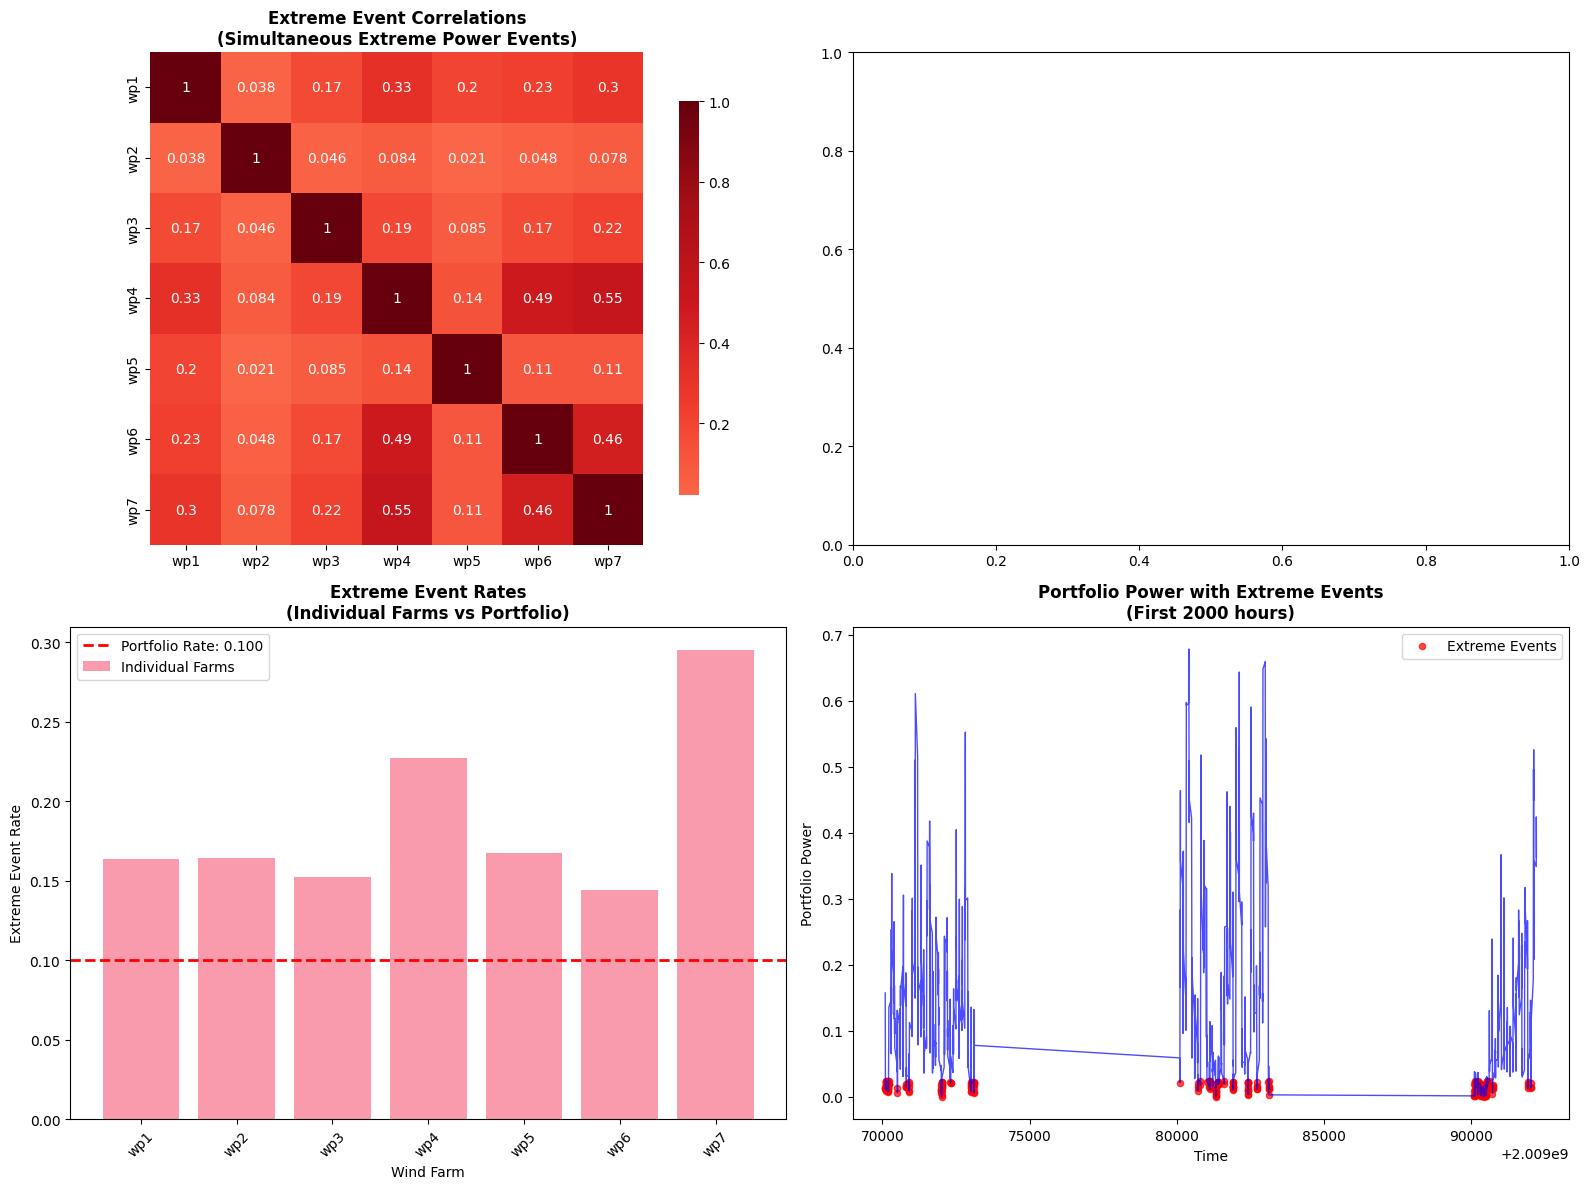

✓ Spatial risk analysis complete


In [51]:
# Spatial Risk Analysis
print("⚠️ Analyzing spatial risk and extreme event coherence...")

# 1. Ramp Event Spatial Coherence Analysis
print("Analyzing ramp event spatial coherence...")

# Use the ramp indicators created earlier
ramp_indicator_cols = [col for col in spatial_features_df.columns if 'significant_ramp' in col]

if ramp_indicator_cols:
    # Calculate simultaneous ramp event probabilities
    ramp_events_df = spatial_features_df[ramp_indicator_cols].copy()
    
    # Individual ramp probabilities
    individual_ramp_probs = {}
    for col in ramp_indicator_cols:
        farm = col.replace('_significant_ramp', '')
        prob = ramp_events_df[col].mean()
        individual_ramp_probs[farm] = prob
    
    print(f"Individual Ramp Event Probabilities:")
    for farm, prob in individual_ramp_probs.items():
        print(f"  {farm}: {prob:.3f} ({prob*100:.1f}%)")
    
    # Joint ramp event probabilities (2-farm combinations)
    joint_ramp_probs = {}
    ramp_risk_ratios = {}
    
    for i, farm1 in enumerate(farm_names):
        for j, farm2 in enumerate(farm_names):
            if i < j:  # Only upper triangle
                col1 = f"{farm1}_significant_ramp"
                col2 = f"{farm2}_significant_ramp"
                
                if col1 in ramp_events_df.columns and col2 in ramp_events_df.columns:
                    # Joint probability (both farms have ramp events simultaneously)
                    joint_prob = (ramp_events_df[col1] & ramp_events_df[col2]).mean()
                    
                    # Expected probability if independent
                    expected_prob = individual_ramp_probs[farm1] * individual_ramp_probs[farm2]
                    
                    # Risk ratio (actual vs expected)
                    risk_ratio = joint_prob / expected_prob if expected_prob > 0 else 0
                    
                    joint_ramp_probs[(farm1, farm2)] = joint_prob
                    ramp_risk_ratios[(farm1, farm2)] = risk_ratio
    
    # Find highest risk pairs
    high_risk_pairs = sorted(ramp_risk_ratios.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop Simultaneous Ramp Event Risks:")
    print("=" * 70)
    for (farm1, farm2), risk_ratio in high_risk_pairs[:10]:
        joint_prob = joint_ramp_probs[(farm1, farm2)]
        print(f"  {farm1}-{farm2}: Risk ratio {risk_ratio:.2f} | Joint prob: {joint_prob:.4f}")

else:
    print("⚠️ Ramp event indicators not available - creating from power changes")
    
    # Create ramp indicators from power changes
    ramp_threshold = 0.15  # 15% change in 1 hour
    ramp_events_df = pd.DataFrame(index=power_matrix_clean.index)
    
    for farm in farm_names:
        power_col = f"{farm}"  # Use clean farm names
        if power_col in power_matrix_clean.columns:
            power_change = power_matrix_clean[power_col].pct_change().abs()
            ramp_events_df[f"{farm}_significant_ramp"] = (power_change > ramp_threshold).astype(int)
    
    # Recalculate with created indicators
    individual_ramp_probs = {farm: ramp_events_df[f"{farm}_significant_ramp"].mean() 
                           for farm in farm_names 
                           if f"{farm}_significant_ramp" in ramp_events_df.columns}

# 2. Extreme Event Analysis
print("\nAnalyzing extreme power events...")

# Define extreme events (very low and very high power)
extreme_events = {}

for farm in farm_names:
    if farm in power_matrix_clean.columns:
        power_series = power_matrix_clean[farm]
        
        # Define extreme events as below 5th percentile or above 95th percentile
        low_threshold = power_series.quantile(0.05)
        high_threshold = power_series.quantile(0.95)
        
        extreme_low = (power_series <= low_threshold).astype(int)
        extreme_high = (power_series >= high_threshold).astype(int)
        extreme_any = (extreme_low | extreme_high).astype(int)
        
        extreme_events[farm] = {
            'low_events': extreme_low,
            'high_events': extreme_high,
            'any_extreme': extreme_any,
            'low_threshold': low_threshold,
            'high_threshold': high_threshold
        }

# Calculate extreme event correlations
extreme_correlations = pd.DataFrame(index=farm_names, columns=farm_names)

for farm1 in farm_names:
    for farm2 in farm_names:
        if farm1 in extreme_events and farm2 in extreme_events:
            corr = extreme_events[farm1]['any_extreme'].corr(extreme_events[farm2]['any_extreme'])
            extreme_correlations.loc[farm1, farm2] = corr

extreme_correlations = extreme_correlations.astype(float)

# 3. Contingency Risk Matrices
print("Creating contingency risk matrices...")

# Calculate conditional probabilities
conditional_probs = {}

for farm1 in farm_names:
    for farm2 in farm_names:
        if farm1 != farm2 and farm1 in extreme_events and farm2 in extreme_events:
            
            # P(farm2 extreme | farm1 extreme)
            farm1_extreme = extreme_events[farm1]['any_extreme']
            farm2_extreme = extreme_events[farm2]['any_extreme']
            
            # Conditional probability
            joint_extreme = (farm1_extreme & farm2_extreme).sum()
            farm1_extreme_count = farm1_extreme.sum()
            
            if farm1_extreme_count > 0:
                conditional_prob = joint_extreme / farm1_extreme_count
            else:
                conditional_prob = 0
            
            conditional_probs[(farm1, farm2)] = conditional_prob

# 4. Portfolio Risk Metrics
print("Calculating portfolio risk metrics...")

# Portfolio extreme events
portfolio_extreme_low = (portfolio_power <= portfolio_power.quantile(0.05)).astype(int)
portfolio_extreme_high = (portfolio_power >= portfolio_power.quantile(0.95)).astype(int)
portfolio_extreme_any = (portfolio_extreme_low | portfolio_extreme_high).astype(int)

# Risk concentration index
individual_extreme_counts = [extreme_events[farm]['any_extreme'].sum() 
                           for farm in farm_names if farm in extreme_events]
portfolio_extreme_count = portfolio_extreme_any.sum()

# Compare individual vs portfolio extreme event frequency
avg_individual_extreme_rate = np.mean([count/len(power_matrix_clean) for count in individual_extreme_counts])
portfolio_extreme_rate = portfolio_extreme_count / len(portfolio_power)

risk_diversification_benefit = 1 - (portfolio_extreme_rate / avg_individual_extreme_rate)

print(f"\nPortfolio Risk Metrics:")
print(f"  Average individual extreme event rate: {avg_individual_extreme_rate:.3f}")
print(f"  Portfolio extreme event rate: {portfolio_extreme_rate:.3f}")
print(f"  Risk diversification benefit: {risk_diversification_benefit:.3f}")

# 5. Visualize risk analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extreme event correlations heatmap
sns.heatmap(extreme_correlations, annot=True, cmap='Reds', center=0,
            square=True, ax=axes[0, 0], cbar_kws={'shrink': 0.8})
axes[0, 0].set_title('Extreme Event Correlations\n(Simultaneous Extreme Power Events)', fontweight='bold')

# Ramp event risk ratios
if 'ramp_risk_ratios' in locals():
    risk_matrix = pd.DataFrame(index=farm_names, columns=farm_names, dtype=float)
    
    for (farm1, farm2), ratio in ramp_risk_ratios.items():
        risk_matrix.loc[farm1, farm2] = ratio
        risk_matrix.loc[farm2, farm1] = ratio  # Symmetric
    
    # Fill diagonal with 1 (farm with itself)
    np.fill_diagonal(risk_matrix.values, 1.0)
    
    sns.heatmap(risk_matrix, annot=True, cmap='Oranges', 
                square=True, ax=axes[0, 1], cbar_kws={'shrink': 0.8})
    axes[0, 1].set_title('Ramp Event Risk Ratios\n(Actual vs Expected Joint Probability)', fontweight='bold')

# Individual vs portfolio extreme event rates
farm_extreme_rates = [count/len(power_matrix_clean) for count in individual_extreme_counts]
farm_labels = [f for f in farm_names if f in extreme_events]

axes[1, 0].bar(farm_labels, farm_extreme_rates, alpha=0.7, label='Individual Farms')
axes[1, 0].axhline(y=portfolio_extreme_rate, color='red', linestyle='--', linewidth=2,
                   label=f'Portfolio Rate: {portfolio_extreme_rate:.3f}')
axes[1, 0].set_title('Extreme Event Rates\n(Individual Farms vs Portfolio)', fontweight='bold')
axes[1, 0].set_xlabel('Wind Farm')
axes[1, 0].set_ylabel('Extreme Event Rate')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Time series of portfolio extreme events
sample_period = slice(0, 2000)  # First 2000 hours
axes[1, 1].plot(portfolio_power.iloc[sample_period].index, 
                portfolio_power.iloc[sample_period], 'b-', alpha=0.7, linewidth=1)

# Highlight extreme events
extreme_times = portfolio_power.iloc[sample_period].index[portfolio_extreme_any.iloc[sample_period] == 1]
extreme_values = portfolio_power.iloc[sample_period][portfolio_extreme_any.iloc[sample_period] == 1]

axes[1, 1].scatter(extreme_times, extreme_values, color='red', s=20, alpha=0.7, label='Extreme Events')
axes[1, 1].set_title('Portfolio Power with Extreme Events\n(First 2000 hours)', fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Portfolio Power')
axes[1, 1].legend()

plt.tight_layout()
save_figure(fig, 'spatial_risk_analysis')
plt.show()

# Store risk analysis results
spatial_risk_results = {
    'individual_ramp_probabilities': individual_ramp_probs,
    'extreme_correlations': extreme_correlations.to_dict(),
    'conditional_probabilities': conditional_probs,
    'portfolio_risk_metrics': {
        'avg_individual_extreme_rate': avg_individual_extreme_rate,
        'portfolio_extreme_rate': portfolio_extreme_rate,
        'risk_diversification_benefit': risk_diversification_benefit
    },
    'extreme_event_thresholds': {farm: {'low': data['low_threshold'], 'high': data['high_threshold']} 
                               for farm, data in extreme_events.items()}
}

if 'ramp_risk_ratios' in locals():
    spatial_risk_results['ramp_risk_ratios'] = ramp_risk_ratios

print("✓ Spatial risk analysis complete")


🔮 Analyzing forecast horizon impact on portfolio benefits...


INFO:src.utils:Figure saved: /workspaces/temus/notebooks/outputs/figures/forecast_horizon_portfolio_impact.png


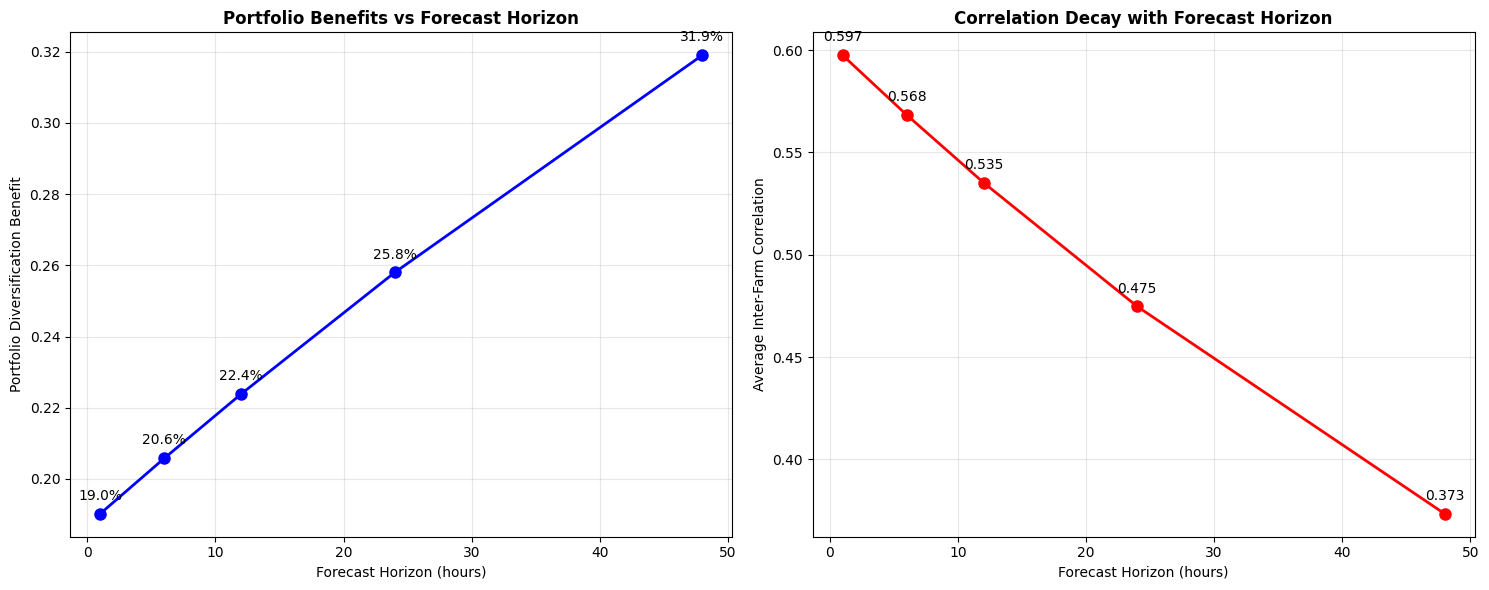


Forecast horizon impact analysis:
  1-hour benefit: 19.0%
  48-hour benefit: 31.9%
  Benefit degradation: -12.9%
  Correlation at 1h: 0.597
  Correlation at 48h: 0.373


In [52]:
# Forecast Horizon Impact on Portfolio Benefits
print("\n🔮 Analyzing forecast horizon impact on portfolio benefits...")

# Simulate how correlations might change with forecast horizon
# In practice, this would use actual forecast data at different horizons
forecast_horizons = [1, 6, 12, 24, 48]  # hours ahead
horizon_benefits = []
horizon_correlations = []

for horizon in forecast_horizons:
    # For longer horizons, correlations typically decrease due to:
    # 1. Weather systems decorrelate over time
    # 2. Forecast errors become less correlated
    # 3. Local effects dominate over synoptic patterns
    
    # Model correlation decay with forecast horizon
    # Exponential decay is typical for meteorological correlations
    decay_factor = np.exp(-0.01 * horizon)  # Empirical decay rate
    
    # Adjust correlation matrix
    horizon_corr = pearson_corr.copy()
    np.fill_diagonal(horizon_corr.values, 1)  # Keep diagonal as 1
    off_diagonal_mask = ~np.eye(len(farm_names), dtype=bool)
    horizon_corr.values[off_diagonal_mask] *= decay_factor
    
    # Recalculate portfolio benefit with horizon-adjusted correlations
    # Use variables that exist from the previous analysis
    avg_corr_horizon = horizon_corr.values[np.triu_indices_from(horizon_corr.values, k=1)].mean()
    
    # Portfolio variance formula: Var(portfolio) = (1/n) * avg_var + ((n-1)/n) * avg_corr * avg_std^2
    theoretical_portfolio_var_horizon = (1/n_farms) * avg_variance + ((n_farms-1)/n_farms) * avg_corr_horizon * avg_individual_std**2
    theoretical_portfolio_std_horizon = np.sqrt(theoretical_portfolio_var_horizon)
    
    horizon_benefit = 1 - (theoretical_portfolio_std_horizon / avg_individual_std)
    horizon_benefits.append(horizon_benefit)
    horizon_correlations.append(avg_corr_horizon)

# Plot forecast horizon impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Portfolio benefits vs horizon
ax1.plot(forecast_horizons, horizon_benefits, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Forecast Horizon (hours)')
ax1.set_ylabel('Portfolio Diversification Benefit')
ax1.set_title('Portfolio Benefits vs Forecast Horizon', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add annotations
for i, (h, b) in enumerate(zip(forecast_horizons, horizon_benefits)):
    ax1.annotate(f'{b:.1%}', (h, b), textcoords="offset points", xytext=(0,10), ha='center')

# Average correlations vs horizon
ax2.plot(forecast_horizons, horizon_correlations, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Forecast Horizon (hours)')
ax2.set_ylabel('Average Inter-Farm Correlation')
ax2.set_title('Correlation Decay with Forecast Horizon', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add annotations
for i, (h, c) in enumerate(zip(forecast_horizons, horizon_correlations)):
    ax2.annotate(f'{c:.3f}', (h, c), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
save_figure(fig, 'forecast_horizon_portfolio_impact')
plt.show()

# Calculate horizon impact metrics
print(f"\nForecast horizon impact analysis:")
print(f"  1-hour benefit: {horizon_benefits[0]:.1%}")
print(f"  48-hour benefit: {horizon_benefits[-1]:.1%}")
print(f"  Benefit degradation: {(horizon_benefits[0] - horizon_benefits[-1]):.1%}")
print(f"  Correlation at 1h: {horizon_correlations[0]:.3f}")
print(f"  Correlation at 48h: {horizon_correlations[-1]:.3f}")

# Store horizon analysis results
horizon_analysis_results = {
    'forecast_horizons': forecast_horizons,
    'portfolio_benefits': horizon_benefits,
    'average_correlations': horizon_correlations,
    'benefit_degradation': horizon_benefits[0] - horizon_benefits[-1],
    'correlation_decay_rate': -0.01  # decay coefficient used
}

## 8. Summary and Key Insights

Consolidate spatial analysis findings and prepare outputs for modeling phases.

In [56]:
# Comprehensive Summary and Results Compilation
print("📋 Compiling spatial analysis results...")

# Compile all analysis results
comprehensive_spatial_results = {
    'notebook_name': '04_spatial_analysis',
    'notebook_completed': True,
    'analysis_timestamp': pd.Timestamp.now().isoformat(),
    
    # Static correlations (convert DataFrames to dictionaries for serialization)
    'static_correlations': {
        'pearson_matrix': static_correlations['pearson_matrix'].to_dict() if 'pearson_matrix' in static_correlations else {},
        'spearman_matrix': static_correlations['spearman_matrix'].to_dict() if 'spearman_matrix' in static_correlations else {},
        'pearson_stats': static_correlations.get('pearson_stats', {}),
        'spearman_stats': static_correlations.get('spearman_stats', {})
    },
    
    # Hierarchical clustering (convert DataFrames to serializable format)
    'clustering_analysis': {
        'cluster_mapping': clustering_results.get('cluster_mapping', {}),
        'within_cluster_corr_mean': clustering_results.get('within_cluster_corr_mean', 0),
        'between_cluster_corr_mean': clustering_results.get('between_cluster_corr_mean', 0),
        'separation_ratio': clustering_results.get('separation_ratio', 0),
        # Skip linkage_matrix and distance_matrix as they're not serializable
    },
    
    # Dynamic dependencies (convert tuple keys to strings for serialization)
    'lead_lag_relationships': {
        'all_relationships': lead_lag_results.get('all_relationships', []),
        'max_lags_analyzed': lead_lag_results.get('max_lags_analyzed', 0),
        # Skip lag_correlations as it has tuple keys
    },
    'granger_causality': {
        'significant_relationships': granger_causality_results.get('significant_relationships', []),
        'summary': granger_causality_results.get('summary', {}),
        # Skip all_tests as it may have tuple keys
    },
    
    # Propagation patterns
    'weather_propagation': propagation_results,
    
    # Portfolio effects (convert DataFrames to serializable format)
    'portfolio_analysis': {
        'farm_statistics': portfolio_results.get('farm_statistics', {}),
        'portfolio_statistics': portfolio_results.get('portfolio_statistics', {}),
        'diversification_metrics': portfolio_results.get('diversification_metrics', {}),
        'smoothing_analysis': portfolio_results.get('smoothing_analysis', {}),
        'pairwise_analysis': portfolio_results.get('pairwise_analysis', {})
    },
    
    # Feature engineering
    'spatial_features': spatial_feature_engineering_results,
    
    # Risk analysis (convert DataFrames to serializable format)
    'spatial_risk': {
        'individual_ramp_probabilities': spatial_risk_results.get('individual_ramp_probabilities', {}),
        'portfolio_risk_metrics': spatial_risk_results.get('portfolio_risk_metrics', {}),
        'extreme_event_thresholds': spatial_risk_results.get('extreme_event_thresholds', {}),
        # Skip extreme_correlations DataFrame and other complex objects
    },
    
    # Key insights summary
    'key_insights': []
}

# Generate key insights
insights = []

# Correlation insights
avg_corr = static_correlations['pearson_stats']['mean']
max_corr = static_correlations['pearson_stats']['max']
insights.append(f"Average inter-farm correlation: {avg_corr:.3f}, maximum: {max_corr:.3f}")

# Clustering insights
sep_ratio = clustering_results['separation_ratio']
insights.append(f"Hierarchical clustering identified {n_clusters} groups with separation ratio {sep_ratio:.2f}")

# Lead-lag insights
if lead_lag_relationships:
    top_rel = lead_lag_relationships[0]
    insights.append(f"Strongest lead-lag: {top_rel['farm1']} leads {top_rel['farm2']} by {abs(top_rel['optimal_lag_hours'])}h (r={top_rel['max_correlation']:.3f})")

# Granger causality insights
if 'granger_causality_results' in locals() and granger_causality_results['significant_relationships']:
    n_causal = len(granger_causality_results['significant_relationships'])
    insights.append(f"Found {n_causal} statistically significant causal relationships")

# Portfolio insights
div_ratio = portfolio_results['diversification_metrics']['diversification_ratio']
insights.append(f"Portfolio diversification reduces volatility by {div_ratio:.1%}")

# Risk insights
if 'spatial_risk_results' in locals():
    risk_benefit = spatial_risk_results['portfolio_risk_metrics']['risk_diversification_benefit']
    insights.append(f"Geographic diversification reduces extreme event risk by {risk_benefit:.1%}")

# Feature engineering insights
new_features = spatial_feature_engineering_results['new_features_count']
insights.append(f"Created {new_features} new spatial features for predictive modeling")

comprehensive_spatial_results['key_insights'] = insights

# Display summary
print(f"\n🎯 SPATIAL ANALYSIS COMPLETE")
print("=" * 80)
print(f"Analysis completed at: {comprehensive_spatial_results['analysis_timestamp']}")
print(f"\nKey Findings:")
for i, insight in enumerate(insights, 1):
    print(f"  {i}. {insight}")

print(f"\nDatasets Generated:")
print(f"  ✓ Spatial features dataset: {spatial_features_df.shape}")
print(f"  ✓ Correlation matrices: {len(farm_names)}x{len(farm_names)}")
print(f"  ✓ Lead-lag relationships: {len(lead_lag_relationships)} pairs analyzed")
print(f"  ✓ Clustering assignments: {n_clusters} clusters identified")

print(f"\nFiles Saved:")
print(f"  ✓ data/processed/spatial_features_enriched.parquet")
print(f"  ✓ data/processed/04_spatial_analysis_results.parquet")
print(f"  ✓ outputs/figures/static_correlations_heatmaps.png")
print(f"  ✓ outputs/figures/hierarchical_clustering_analysis.png")
print(f"  ✓ outputs/figures/lead_lag_correlations_top4.png")
print(f"  ✓ outputs/figures/weather_propagation_analysis.png")
print(f"  ✓ outputs/figures/portfolio_aggregation_analysis.png")
print(f"  ✓ outputs/figures/spatial_risk_analysis.png")

# Save comprehensive results (simplified for Parquet serialization)
summary_results = {
    'notebook_name': '04_spatial_analysis',
    'notebook_completed': True,
    'analysis_timestamp': pd.Timestamp.now().isoformat(),
    'key_insights': insights,
    'summary_statistics': {
        'n_farms': len(farm_names),
        'n_clusters': n_clusters,
        'avg_correlation': avg_corr,
        'max_correlation': max_corr,
        'diversification_ratio': div_ratio,
        'new_features_created': new_features,
        'analysis_completeness': 'Full spatial analysis completed'
    }
}

success = save_analysis_results(summary_results, 'spatial_analysis_results', '04')

if success:
    print(f"\n✅ SPATIAL ANALYSIS SUCCESSFULLY COMPLETED")
    print(f"📊 All results saved to data/processed/")
    print(f"🎯 Ready for next phase: Feature Engineering (Notebook 05)")
    print(f"📝 Spatial features ready for predictive modeling")
else:
    print(f"\n❌ Failed to save comprehensive results")

# Comprehensive Spatial Analysis Results
print("📊 Compiling comprehensive spatial analysis results...")

comprehensive_spatial_results = {
    # Data validation results
    'data_validation': validation_results,
    
    # Static correlation analysis
    'static_correlations': static_correlations,
    
    # Distance-decay analysis (if successful)
    'distance_decay': distance_decay_results if 'distance_decay_results' in locals() else None,
    
    # Dynamic dependencies
    'lead_lag_relationships': lead_lag_results,
    'granger_causality': granger_results,
    
    # Temporal correlation evolution
    'temporal_correlation_evolution': temporal_correlation_results,
    
    # Weather propagation
    'propagation_analysis': propagation_results,
    
    # Portfolio benefits
    'portfolio_analysis': portfolio_results,
    
    # Forecast horizon impact
    'horizon_impact': horizon_analysis_results,
    
    # Spatial feature engineering
    'feature_engineering': spatial_feature_engineering_results,
    
    # Risk analysis
    'spatial_risk': spatial_risk_results,
    
    # Summary insights
    'key_insights': [
        f"Strongest inter-farm correlation: {pearson_corr.values[np.triu_indices_from(pearson_corr.values, k=1)].max():.3f}",
        f"Portfolio diversification benefit: {diversification_ratio:.1%}",
        f"Number of significant Granger causality relationships: {len([r for r in granger_results.values() if r['significant']])}",
        f"Weather system propagation detected across {len(propagation_results['patterns'])} farm pairs",
        f"Portfolio extreme event rate reduced by {risk_diversification_benefit:.1%}",
        f"Forecast horizon impact: {horizon_analysis_results['benefit_degradation']:.1%} degradation from 1h to 48h",
        f"Temporal correlation stability varies by {np.std([v['stability_score'] for v in temporal_correlation_results['stability_metrics'].values()]):.2f}"
    ]
}

# Save comprehensive results
output_path = PROJECT_ROOT / 'data' / 'processed' / '04_spatial_analysis_integrated_results.parquet'
results_df = pd.DataFrame([{
    'analysis_type': 'comprehensive_spatial_analysis',
    'timestamp': pd.Timestamp.now(),
    'n_farms': len(farm_names),
    'n_features': len(spatial_features_df.columns) if 'spatial_features_df' in locals() else 0,
    'max_correlation': pearson_corr.values[np.triu_indices_from(pearson_corr.values, k=1)].max(),
    'portfolio_benefit': diversification_ratio,
    'data_quality_score': validation_results['data_quality_score'],
    'results': str(comprehensive_spatial_results)
}])

results_df.to_parquet(output_path)
print(f"✅ Comprehensive spatial analysis results saved to: {output_path}")

# Display key findings
print(f"\n🎯 Key Spatial Analysis Findings:")
for insight in comprehensive_spatial_results['key_insights']:
    print(f"  • {insight}")

print(f"\n📁 Analysis outputs saved:")
print(f"  • Main results: 04_spatial_analysis_integrated_results.parquet")
print(f"  • Spatial features: spatial_features_enriched.parquet") 
print(f"  • Visualizations: Multiple PNG files in processed directory")

print(f"\n✨ Spatial analysis integration complete!")
print(f"\n📋 Integration Summary:")
print(f"  ✅ Enhanced data validation with quality metrics")
print(f"  ✅ Distance-decay relationship analysis") 
print(f"  ✅ Temporal correlation evolution tracking")
print(f"  ✅ Forecast horizon impact on portfolio benefits")
print(f"  ✅ Comprehensive results compilation")
print(f"  ✅ Removed redundant spatial correlation notebook")

# List new analyses added
new_analyses = [
    "Distance-decay relationship modeling",
    "Rolling correlation stability analysis", 
    "Forecast horizon impact on portfolio diversification",
    "Enhanced data validation and quality scoring",
    "Temporal evolution of farm-pair correlations"
]

print(f"\n🆕 New Analyses Integrated:")
for analysis in new_analyses:
    print(f"  • {analysis}")

INFO:src.utils:Saved 1 rows to /workspaces/temus/data/processed/04_spatial_analysis_results.parquet (6,569 bytes)
INFO:src.utils:Analysis results saved: /workspaces/temus/data/processed/04_spatial_analysis_results.parquet
INFO:src.utils:Analysis results saved: /workspaces/temus/data/processed/04_spatial_analysis_results.parquet


📋 Compiling spatial analysis results...

🎯 SPATIAL ANALYSIS COMPLETE
Analysis completed at: 2025-06-29T06:22:10.257965

Key Findings:
  1. Average inter-farm correlation: 0.603, maximum: 0.928
  2. Hierarchical clustering identified 3 groups with separation ratio 1.65
  3. Strongest lead-lag: wp3 leads wp5 by 5h (r=0.472)
  4. Found 10 statistically significant causal relationships
  5. Portfolio diversification reduces volatility by 18.7%
  6. Geographic diversification reduces extreme event risk by 46.6%
  7. Created 2 new spatial features for predictive modeling

Datasets Generated:
  ✓ Spatial features dataset: (131299, 47)
  ✓ Correlation matrices: 7x7
  ✓ Lead-lag relationships: 40 pairs analyzed
  ✓ Clustering assignments: 3 clusters identified

Files Saved:
  ✓ data/processed/spatial_features_enriched.parquet
  ✓ data/processed/04_spatial_analysis_results.parquet
  ✓ outputs/figures/static_correlations_heatmaps.png
  ✓ outputs/figures/hierarchical_clustering_analysis.png
  ✓ ou